<a href="https://colab.research.google.com/github/visheshkasturia/India-Air-Pollution-Analysis/blob/master/TestAirPollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==0.23.4


# Demographic Monitoring of Air Quality and its Prediction-using Time Series Analysis, Neural Network and IoT based prototype

# Importing necessary libraries

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler
%tensorflow_version 1.x magic
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
import seaborn as sns
from keras.models import load_model
#import matplotlib.pyplot as plt
#import geopandas as gpd

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x magic`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
!pip install pandas_profiling


## Importing the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path= "/content/drive/My Drive/data/data2.csv"

In [ ]:
df=pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


stn_code       sampling_date    ...    pm2_5      date
0      150  February - M021990    ...      NaN  01/02/90
1      151  February - M021990    ...      NaN  01/02/90
2      152  February - M021990    ...      NaN  01/02/90
3      150     March - M031990    ...      NaN  01/03/90
4      151     March - M031990    ...      NaN  01/03/90

[5 rows x 13 columns]

#Dataset Profile and Converting Dataset to Datetime Object

In [ ]:
print('Dataset shape:{}'.format(df.shape))
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%y') # date parse
pandas_profiling.ProfileReport(df)


Dataset shape:(435742, 13)


## It can be seen datatype of date is changed to Datetime


In [ ]:
#print(df["date"])


# Null Values
---



In [ ]:
def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total / len(df) * 100
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")

In [ ]:
printNullValues(df)

                              Total    Percent
pm2_5                        426428  97.862497
spm                          237387  54.478797
agency                       149481  34.304933
stn_code                     144077  33.064749
rspm                          40222   9.230692
so2                           34646   7.951035
location_monitoring_station   27491   6.309009
no2                           16233   3.725370
type                           5393   1.237659
date                              7   0.001606
location                          3   0.000688
sampling_date                     3   0.000688
-------------


In [ ]:
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(df["year"].min())
df['year'] = df['year'].values.astype(int)

In [ ]:
sns.set(style="whitegrid", palette="colorblind")

# Data Analysis of India

### NO2

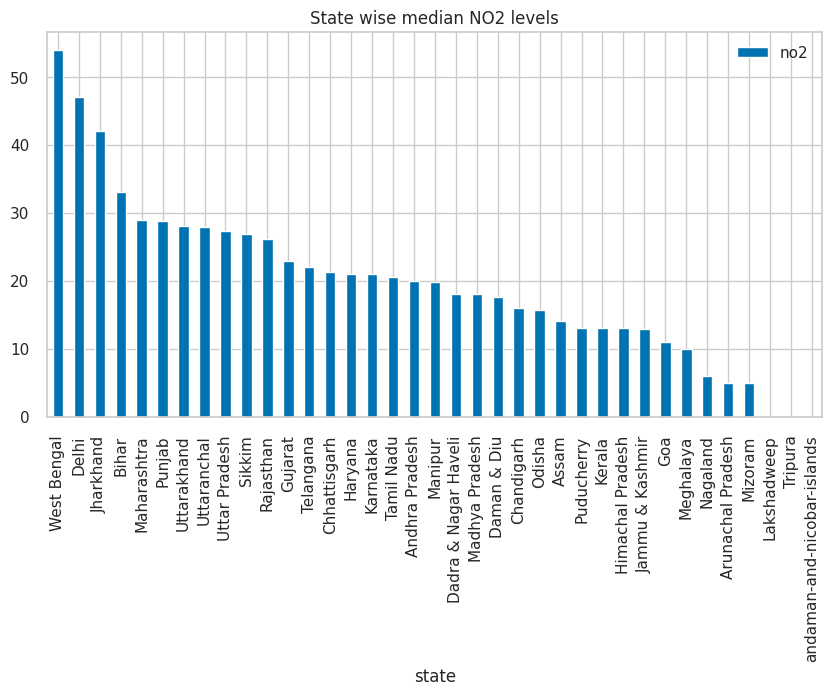

In [ ]:
df[['no2', 'state']].groupby(['state']).median().sort_values("no2", ascending = False).plot.bar(title="State wise median NO2 levels",figsize=(10,5))

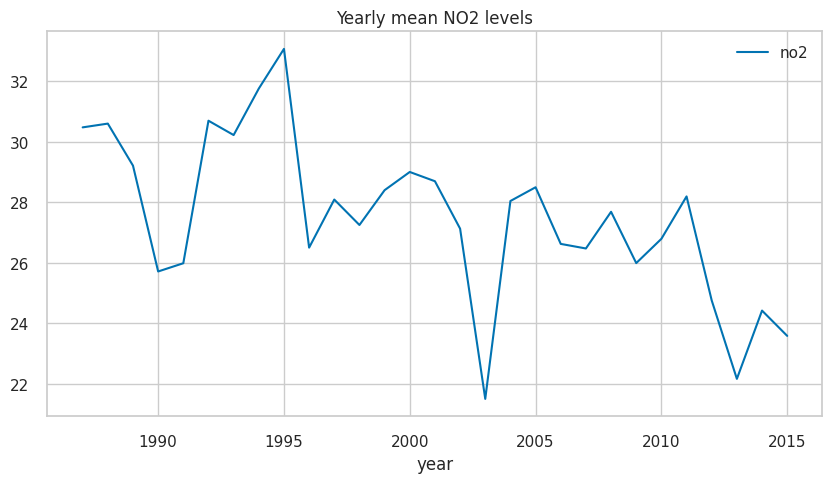

In [ ]:
df[['no2','year','state']].groupby(["year"]).mean().sort_values(by='year',ascending=False).plot(title="Yearly mean NO2 levels",figsize=(10,5))

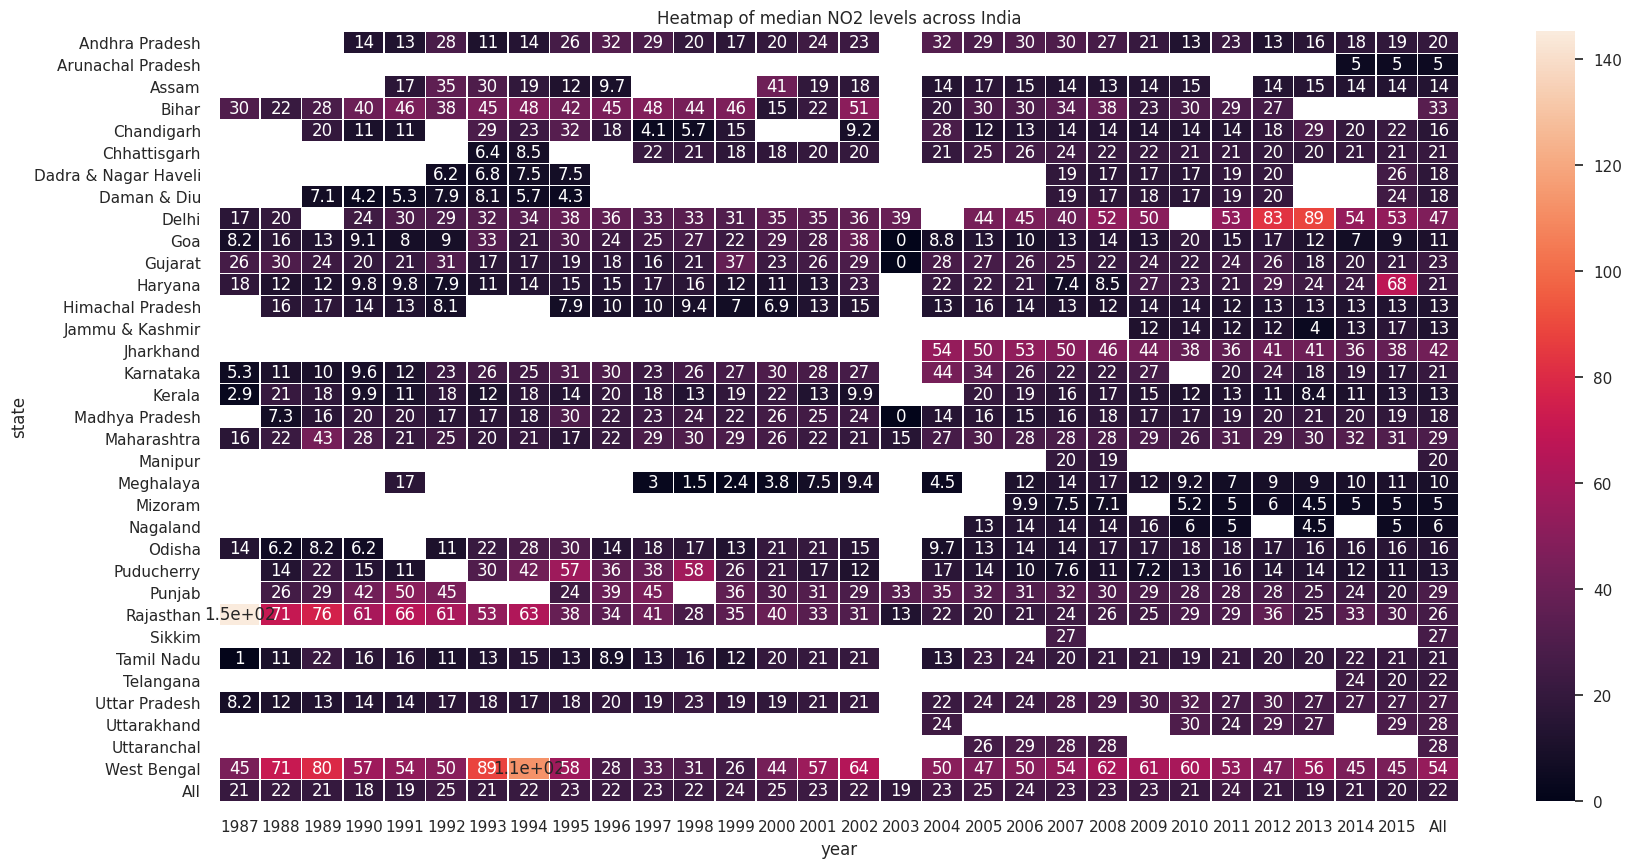

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Heatmap of median NO2 levels across India")   
sns.heatmap(df.pivot_table('no2', index='state',columns=['year'],aggfunc='median',margins=True),ax = ax,annot=True, linewidths=.5)

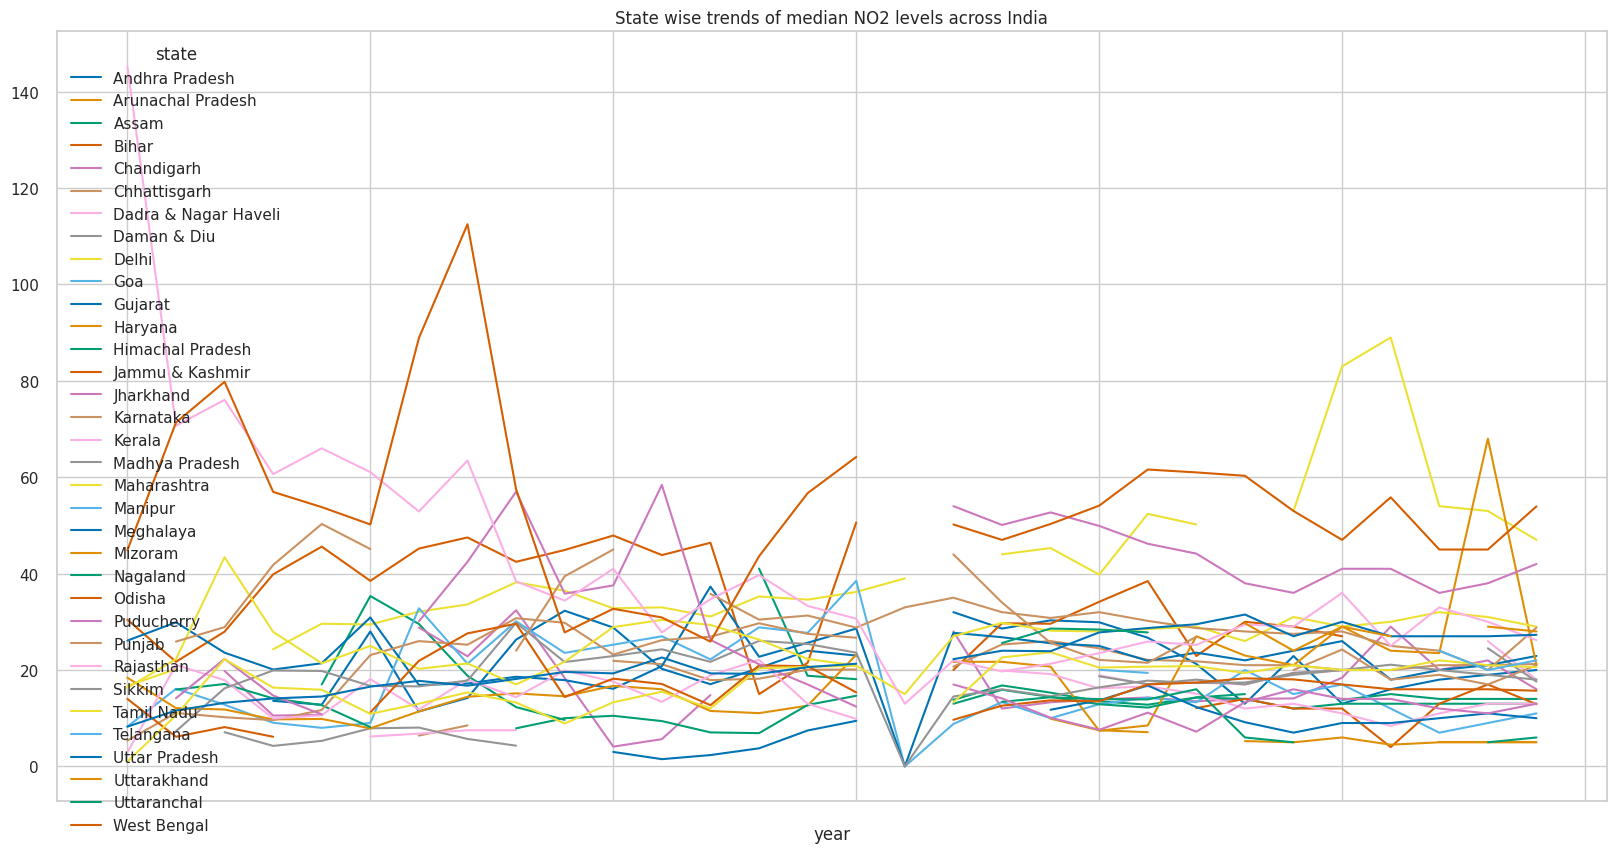

In [ ]:
temp = df.pivot_table('no2', index='year',columns=['state'],aggfunc='median',margins=True).reset_index()
temp = temp.drop("All", axis = 1)
temp = temp.set_index("year")
temp.plot(title="State wise trends of median NO2 levels across India",figsize=(20,10))

### SO2

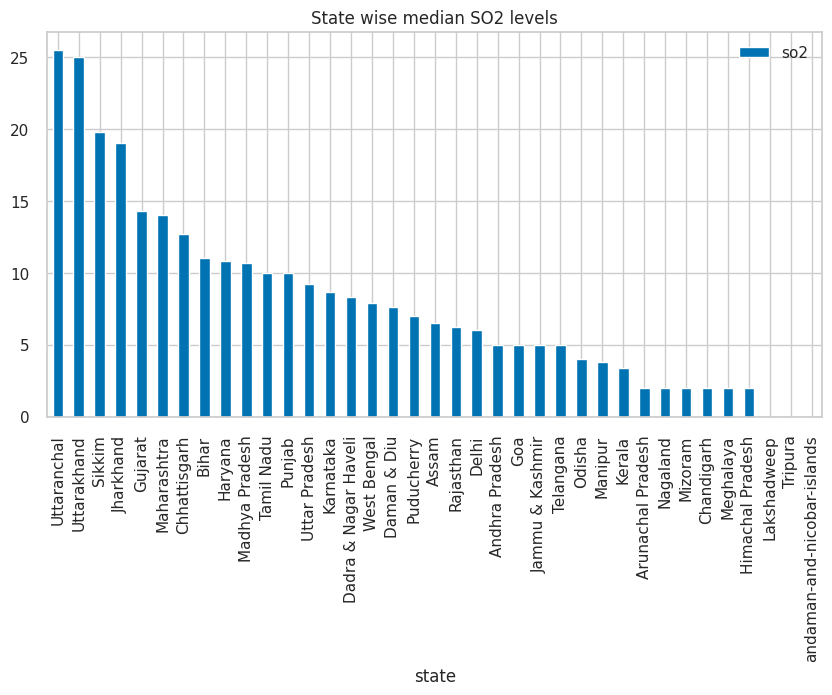

In [ ]:
df[['so2', 'state']].groupby(['state']).median().sort_values("so2", ascending = False).plot.bar(title="State wise median SO2 levels",figsize=(10,5))

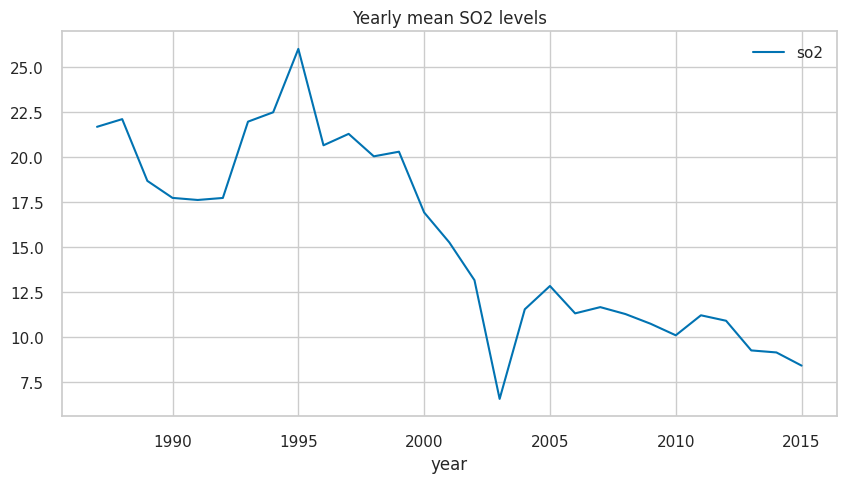

In [ ]:
df[['so2','year','state']].groupby(["year"]).mean().sort_values(by='year',ascending=False).plot(title="Yearly mean SO2 levels",figsize=(10,5))

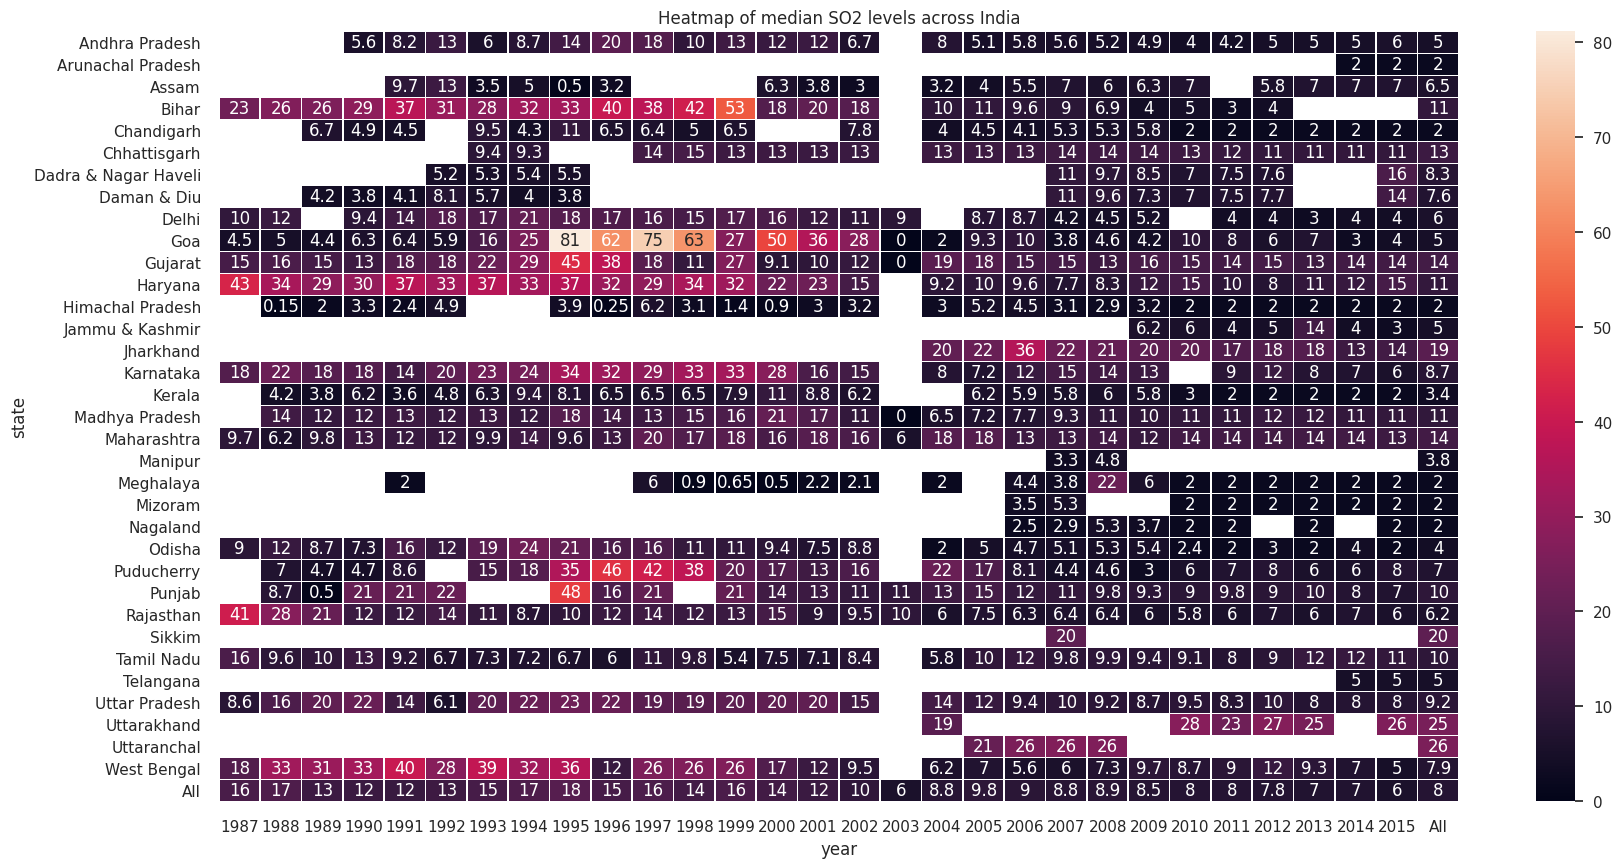

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))   
ax.set_title("Heatmap of median SO2 levels across India")     
sns.heatmap(df.pivot_table('so2', index='state',columns=['year'],aggfunc='median',margins=True),ax = ax,annot=True, linewidths=.5)

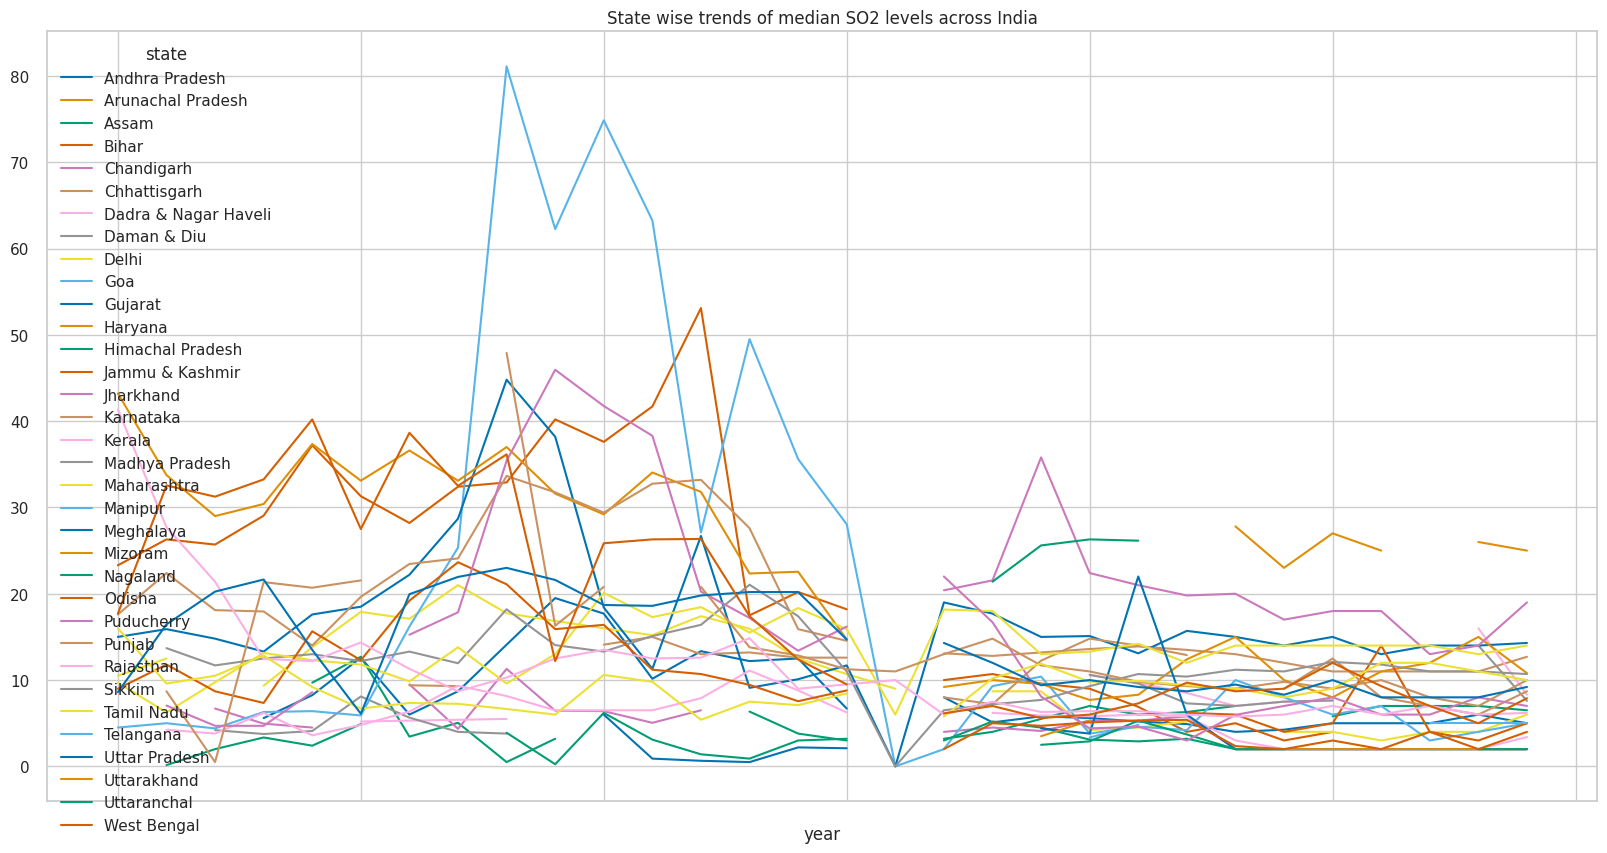

In [ ]:
temp = df.pivot_table('so2', index='year',columns=['state'],aggfunc='median',margins=True).reset_index()
temp = temp.drop("All", axis = 1)
temp = temp.set_index("year")
temp.plot(title="State wise trends of median SO2 levels across India",figsize=(20,10))

### PM2.5

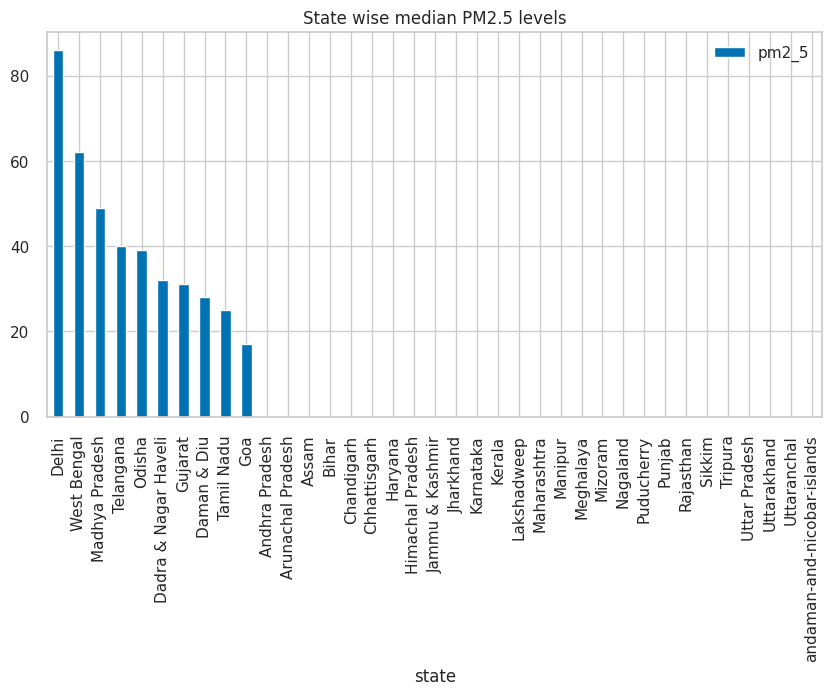

In [ ]:
df[['pm2_5', 'state']].groupby(['state']).median().sort_values("pm2_5", ascending = False).plot.bar(title="State wise median PM2.5 levels",figsize=(10,5))

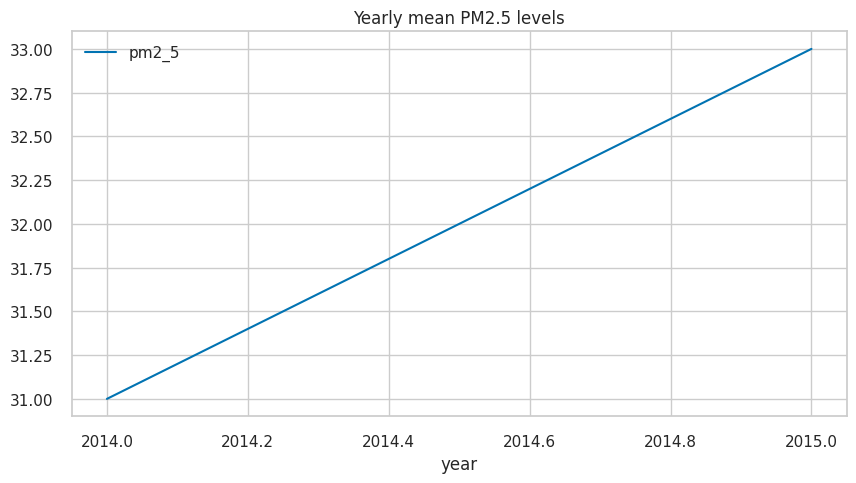

In [ ]:
df[['pm2_5','year','state']].groupby(["year"]).median().sort_values(by='year',ascending=False).plot(title="Yearly mean PM2.5 levels",figsize=(10,5))

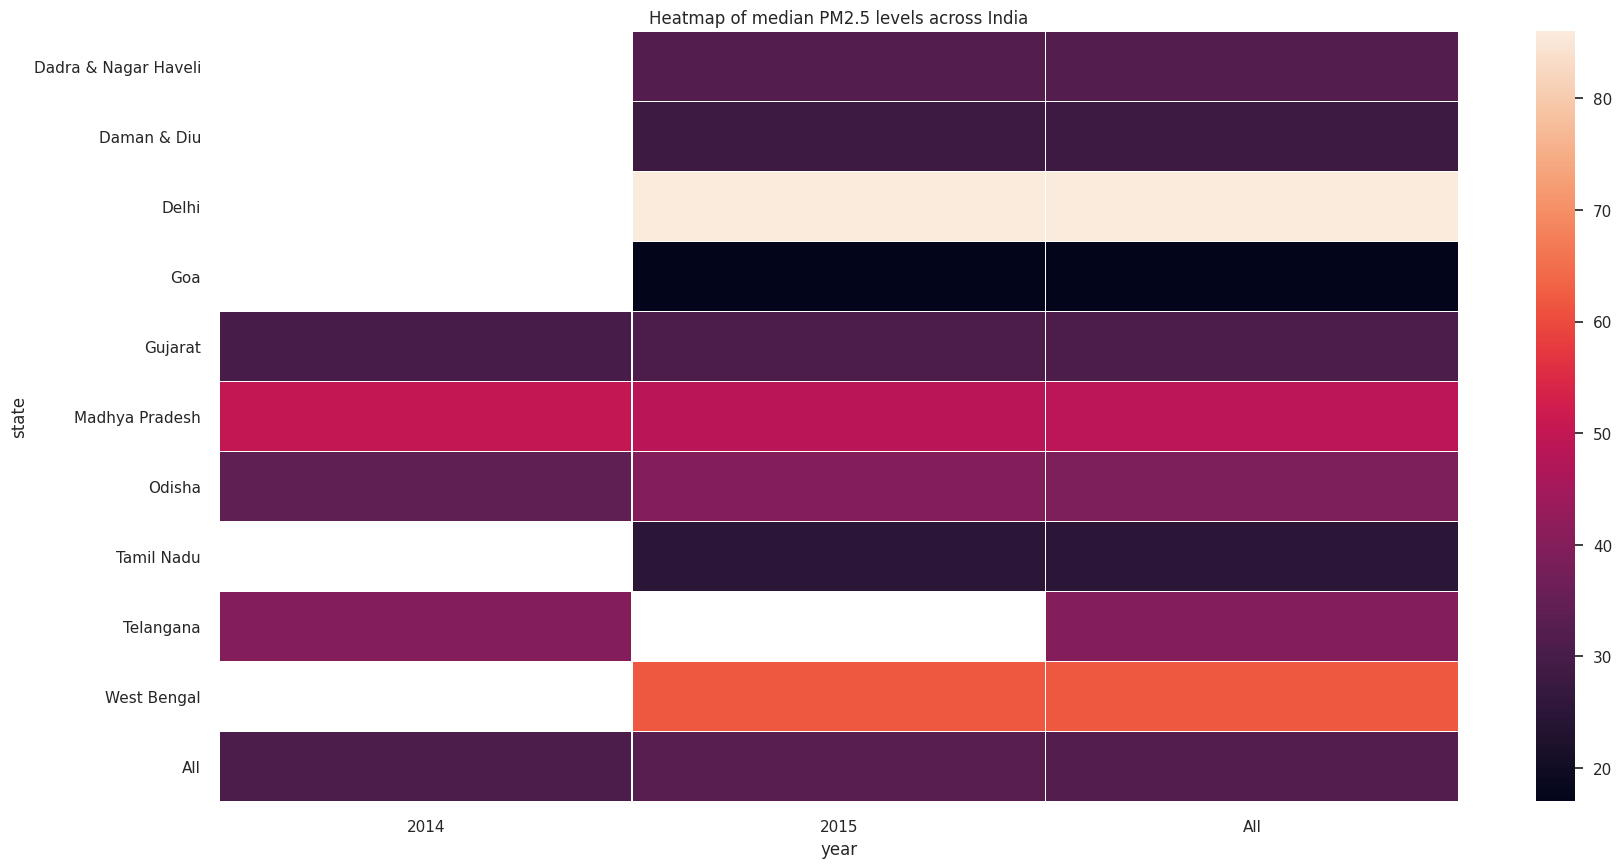

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))   
ax.set_title("Heatmap of median PM2.5 levels across India")    
sns.heatmap(df.pivot_table('pm2_5', index='state',columns=['year'],aggfunc='median',margins=True),ax = ax,annot=False, linewidths=.5)

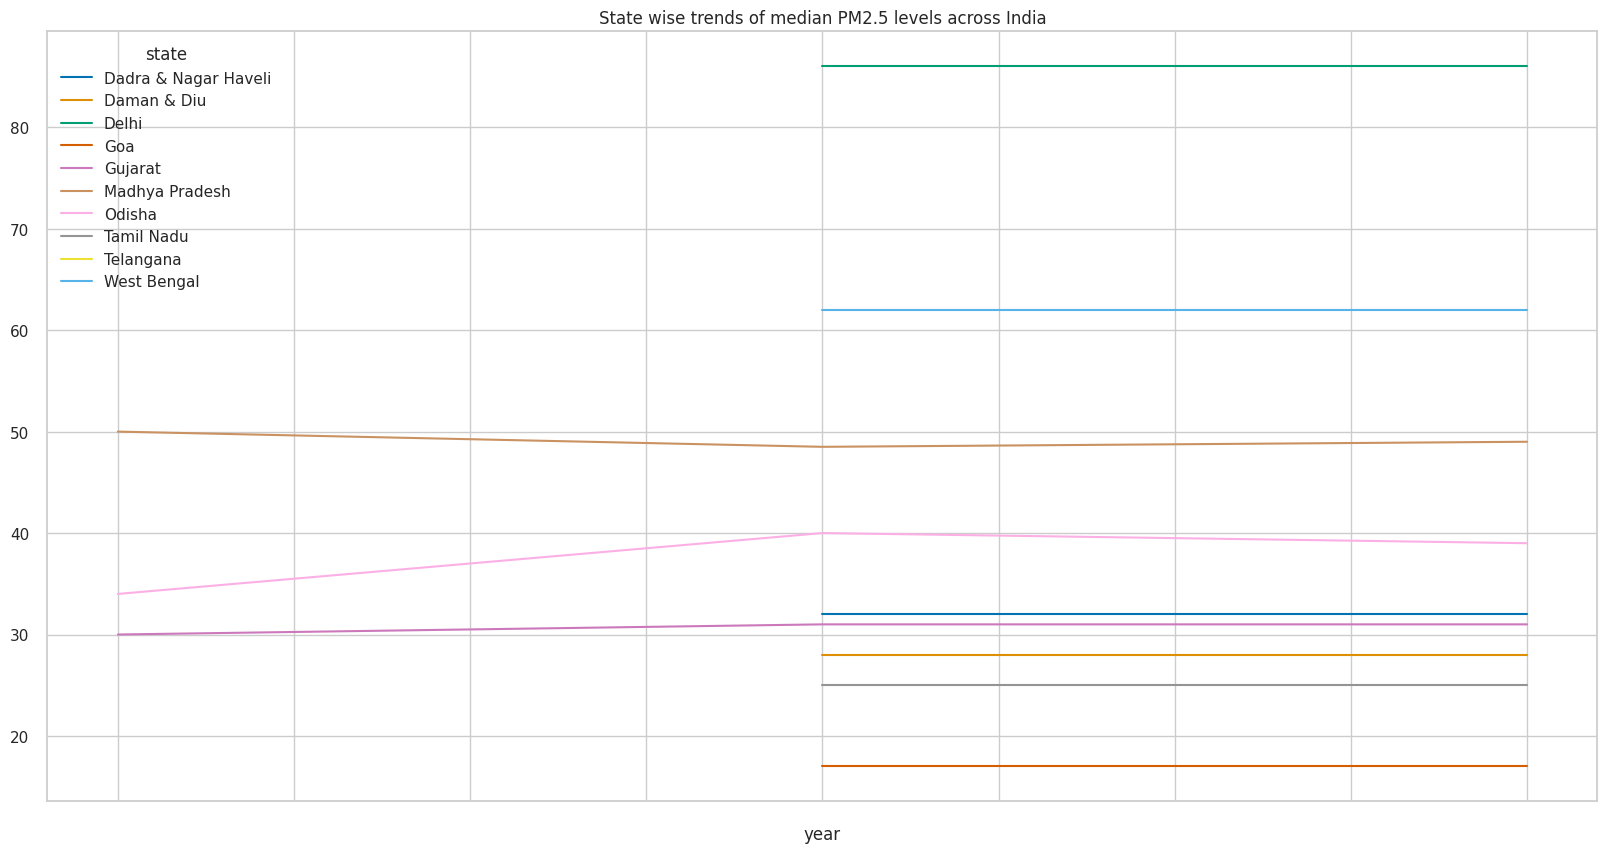

In [ ]:
temp = df.pivot_table('pm2_5', index='year',columns=['state'],aggfunc='median',margins=True).reset_index()
temp = temp.drop("All", axis = 1)
temp = temp.set_index("year")
temp.plot(title="State wise trends of median PM2.5 levels across India",figsize=(20,10))

### SPM


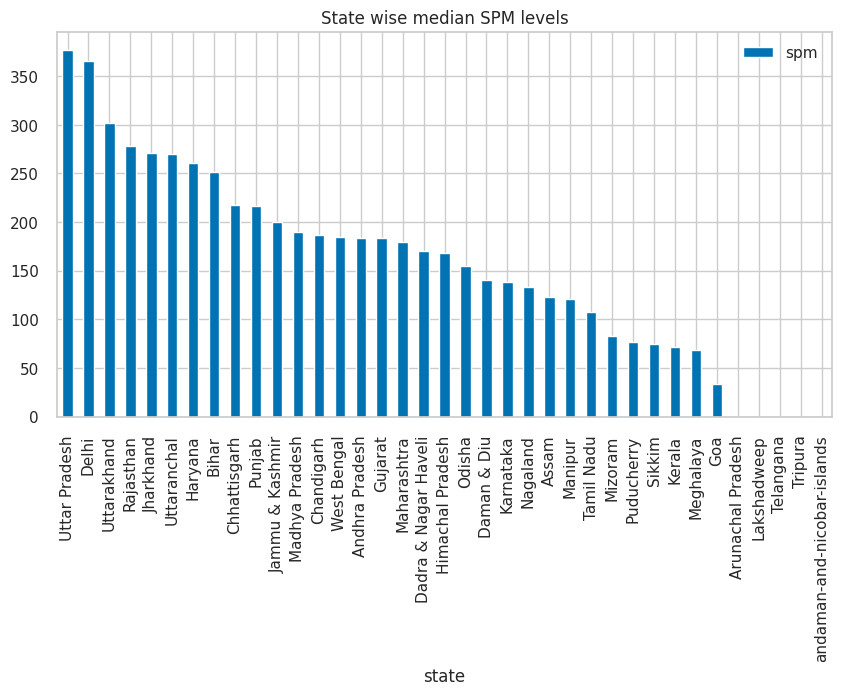

In [ ]:
df[['spm', 'state']].groupby(['state']).median().sort_values("spm", ascending = False).plot.bar(title="State wise median SPM levels",figsize=(10,5))

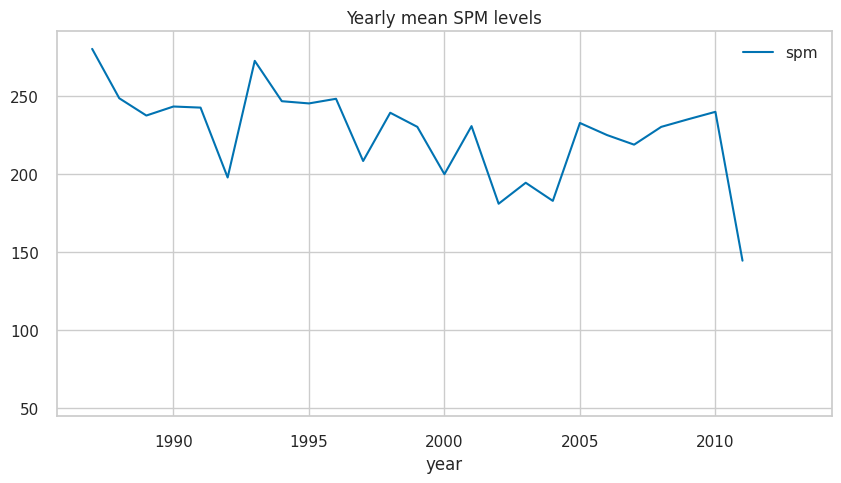

In [ ]:
df[['spm','year','state']].groupby(["year"]).mean().sort_values(by='year',ascending=False).plot(title="Yearly mean SPM levels",figsize=(10,5))

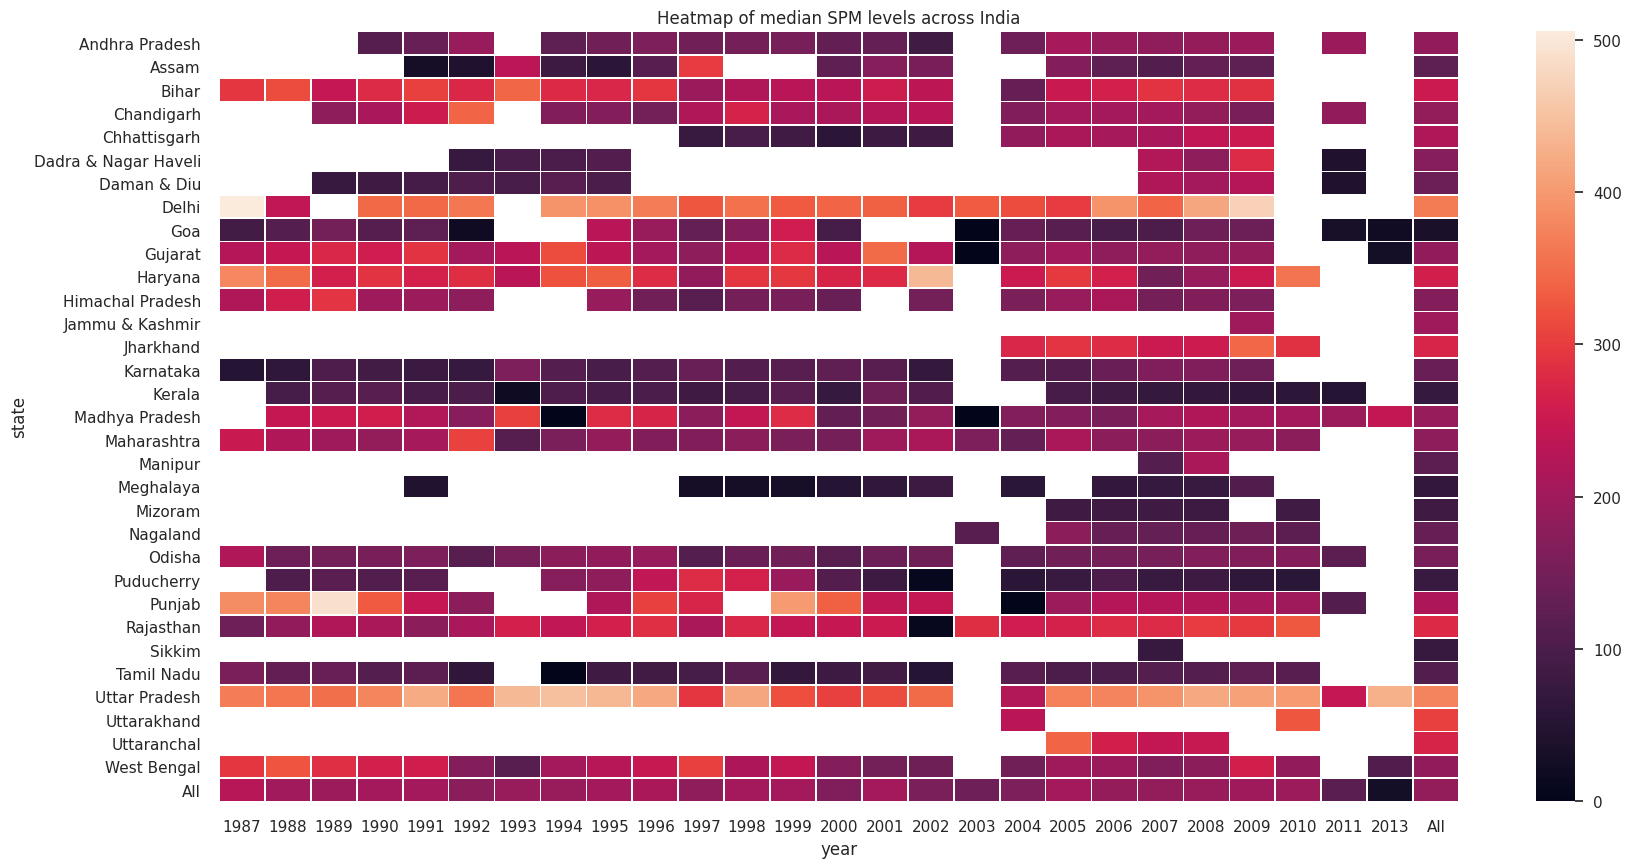

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))      
ax.set_title("Heatmap of median SPM levels across India") 
sns.heatmap(df.pivot_table('spm', index='state',columns=['year'],aggfunc='median',margins=True),ax = ax,annot=False, linewidths=.5)

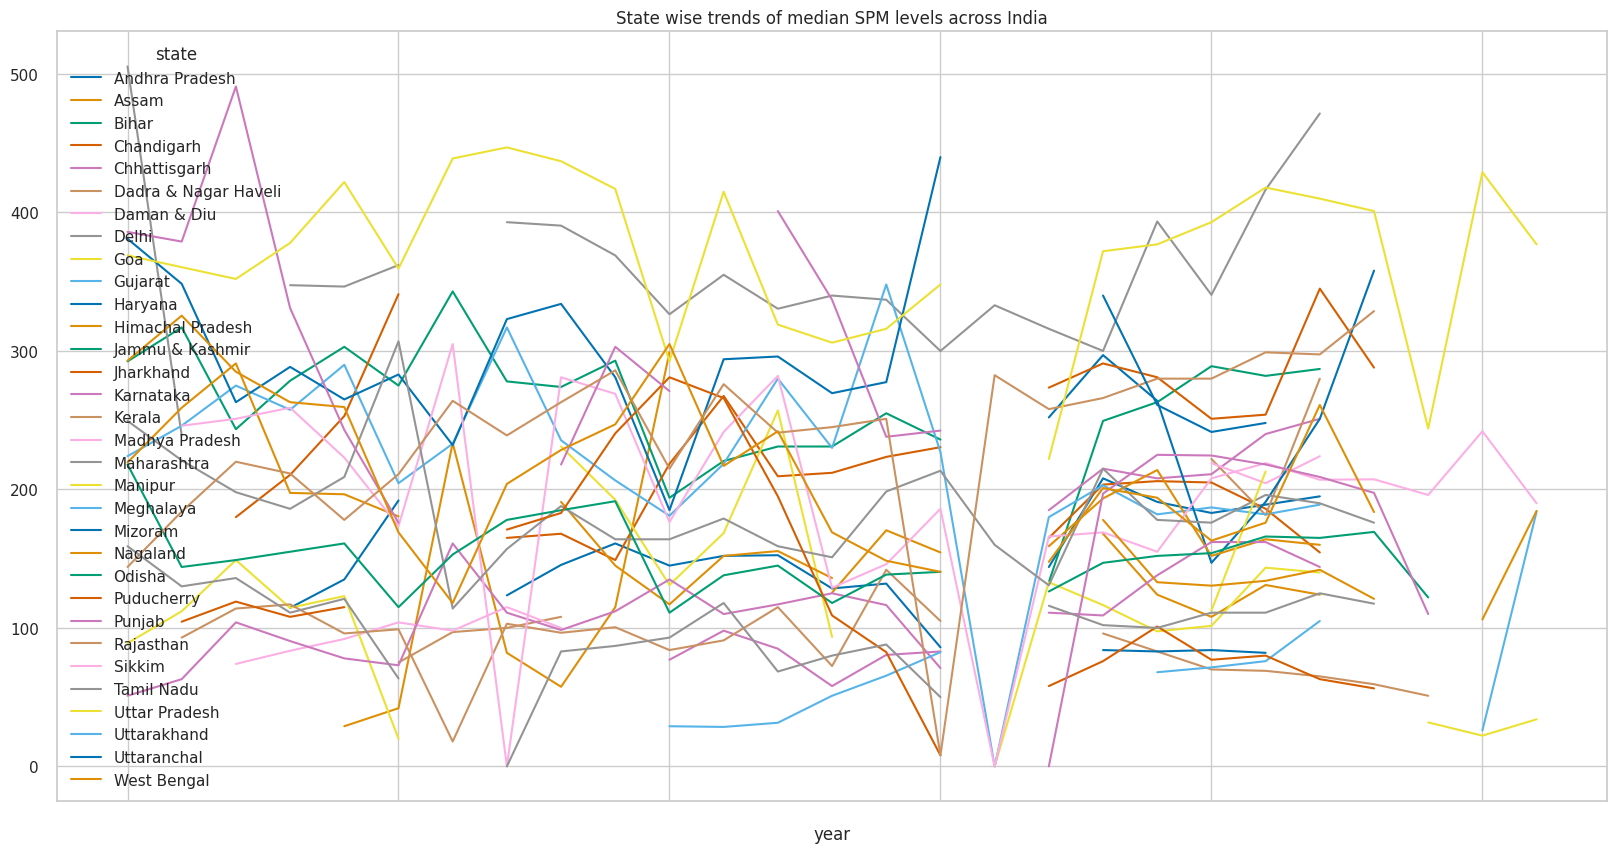

In [ ]:
temp = df.pivot_table('spm', index='year',columns=['state'],aggfunc='median',margins=True).reset_index()
temp = temp.drop("All", axis = 1)
temp = temp.set_index("year")
temp.plot(title="State wise trends of median SPM levels across India",figsize=(20,10))

# Interfacing with User to provide all information about their state

In [ ]:
custom_state=input()
df_custom=df.loc[df['state'] == custom_state]

Delhi


In [ ]:
print("The dataset of {} looks like:".format(custom_state))
print()
print(df_custom)


The dataset of Delhi looks like:

      stn_code sampling_date  state  ...   pm2_5       date  year
65861       60      09/01/87  Delhi  ...     NaN 1987-01-09  1987
65862       59      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65863       58      09/03/87  Delhi  ...     NaN 1987-03-09  1987
65864       57      09/03/87  Delhi  ...     NaN 1987-03-09  1987
65865       56      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65866       55      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65867       60      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65868       59      10/04/87  Delhi  ...     NaN 1987-04-10  1987
65869       58      10/01/87  Delhi  ...     NaN 1987-01-10  1987
65870       57      10/01/87  Delhi  ...     NaN 1987-01-10  1987
65871       56      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65872       55      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65873       60      11/02/87  Delhi  ...     NaN 1987-02-11  1987
65874       59      11/03/87  Delhi  ...  

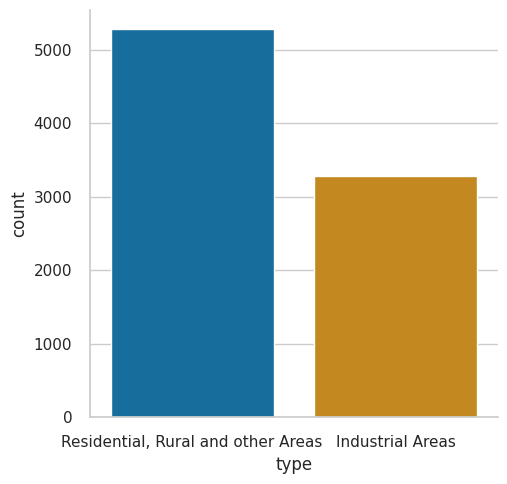

In [ ]:
sns.catplot(x = "type", kind = "count",  data = df_custom, height=5, aspect = 1)

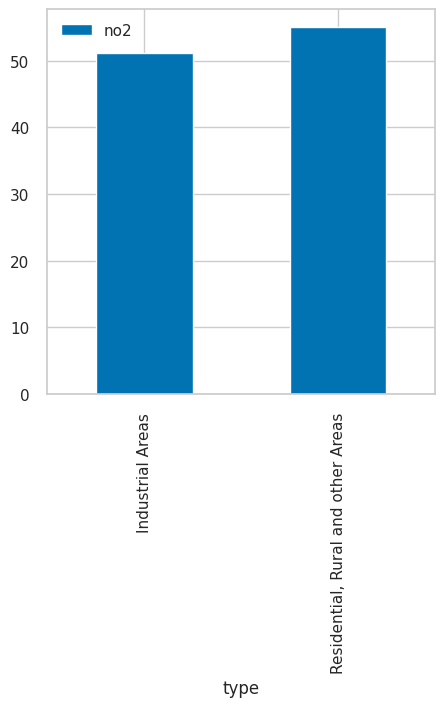

In [ ]:
grp_custom = df_custom.groupby(["type"]).mean()["no2"].to_frame()
grp_custom.plot.bar(figsize = (5,5))

In [ ]:
# grp_custom = df_custom.groupby(["stn_code"]).mean()["no2"].to_frame()
# grp_custom.plot.bar(figsize = (10,5))

You should buy house around the station code where no2 is minumum
                no2
stn_code           
60        36.635857


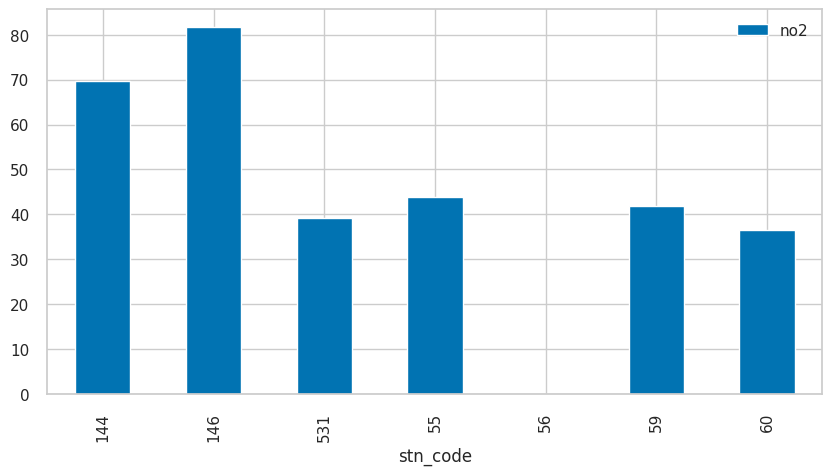

In [ ]:
df_custom_house=df_custom.query('type == "Residential, Rural and other Areas"')
#print(df_custom_house)
grp_custom_house = df_custom_house.groupby(["stn_code"]).mean()["no2"].to_frame()
grp_custom_house.plot.bar(figsize = (10,5))
#print(grp_custom_house)
buy_house=df_custom_house.groupby(['stn_code']).mean()['no2'].to_frame()
buy_house_min=[buy_house['no2'].min()]
print("You should buy house around the station code where no2 is minumum")
print(buy_house[buy_house.no2 == buy_house.no2.min()]) 

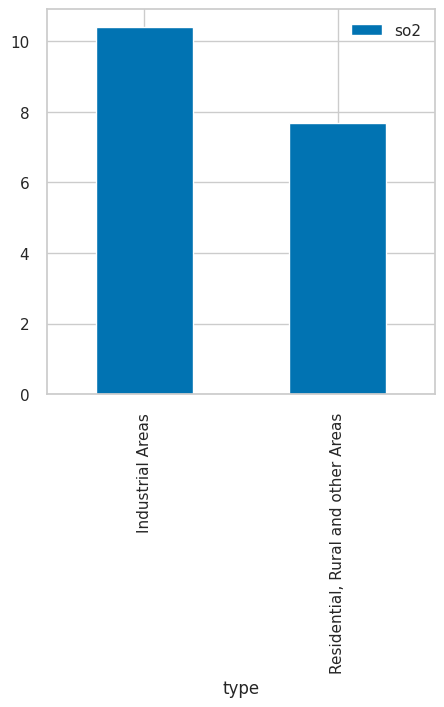

In [ ]:
grp_custom = df_custom.groupby(["type"]).mean()["so2"].to_frame()
grp_custom.plot.bar(figsize = (5,5))

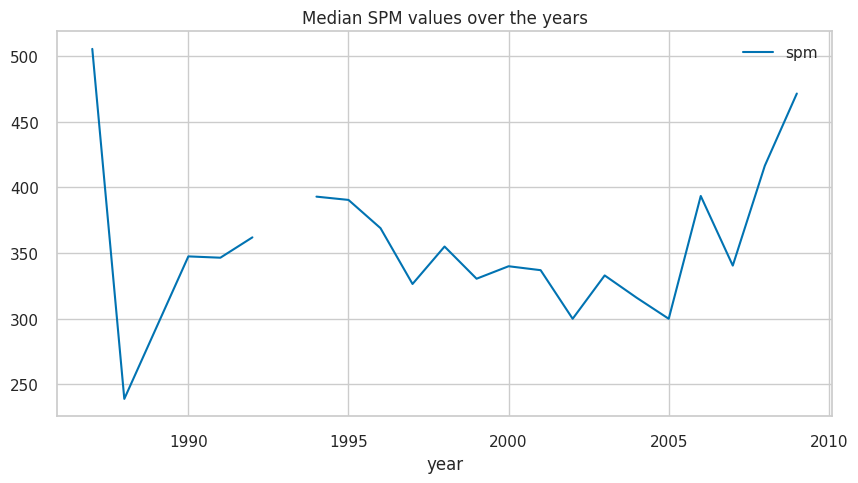

In [ ]:
df_custom[['spm','year','state']].groupby(["year"]).median().sort_values(by='year',ascending=False).plot(title="Median SPM values over the years",figsize=(10,5))

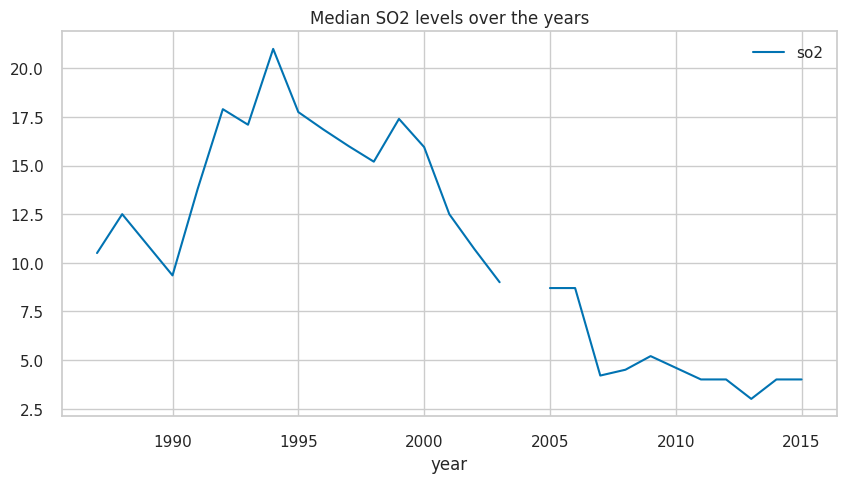

In [ ]:
df_custom[['so2','year','state']].groupby(["year"]).median().sort_values(by='year',ascending=False).plot(title="Median SO2 levels over the years",figsize=(10,5))

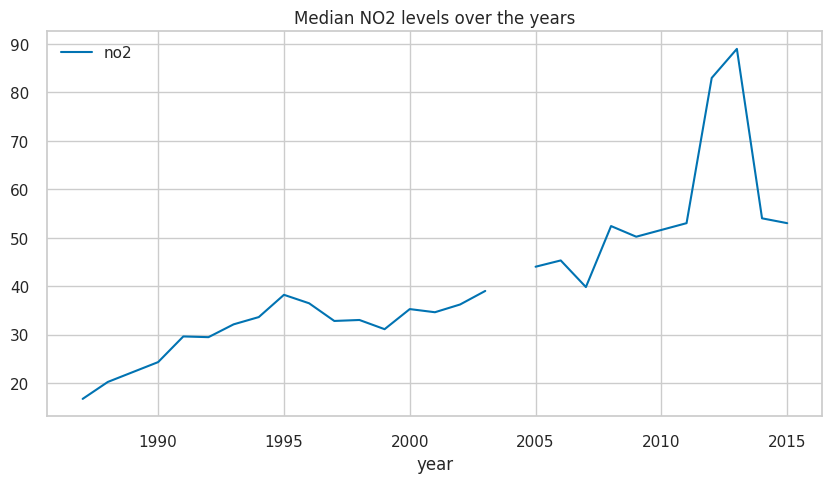

In [ ]:
df_custom[['no2','year','state']].groupby(["year"]).median().sort_values(by='year',ascending=False).plot(title="Median NO2 levels over the years",figsize=(10,5))

# Predicting Air Pollution using Seasonal Auto Regression Integrated Moving Average

In [ ]:
df_custom_no2 = df_custom[["date", "no2"]]
df_custom_no2 = df_custom_no2.set_index("date")
df_custom_no2 = df_custom_no2.dropna()
df_custom_filled_no2=df_custom_no2.ffill()
df_no2_resample_custom = df_custom_no2.resample(rule = "M").mean().ffill()

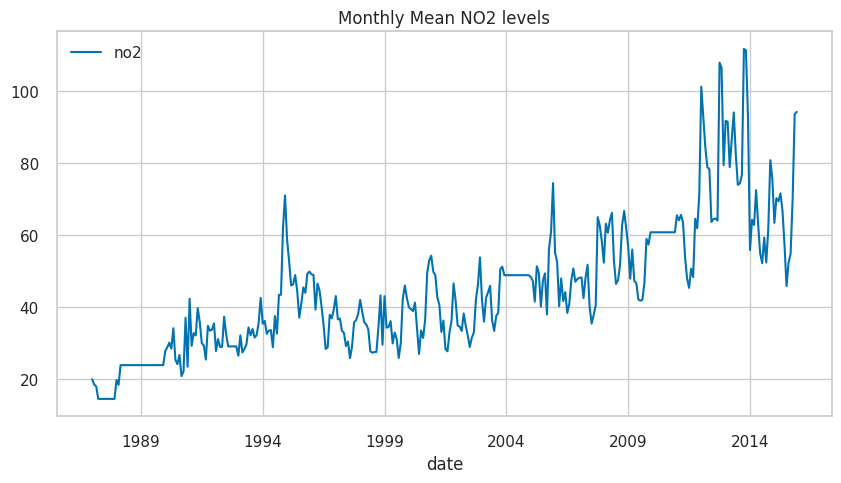

In [ ]:
df_no2_resample_custom.plot(title="Monthly Mean NO2 levels",figsize = (10,5))

### Annual mean Plot

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1209: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


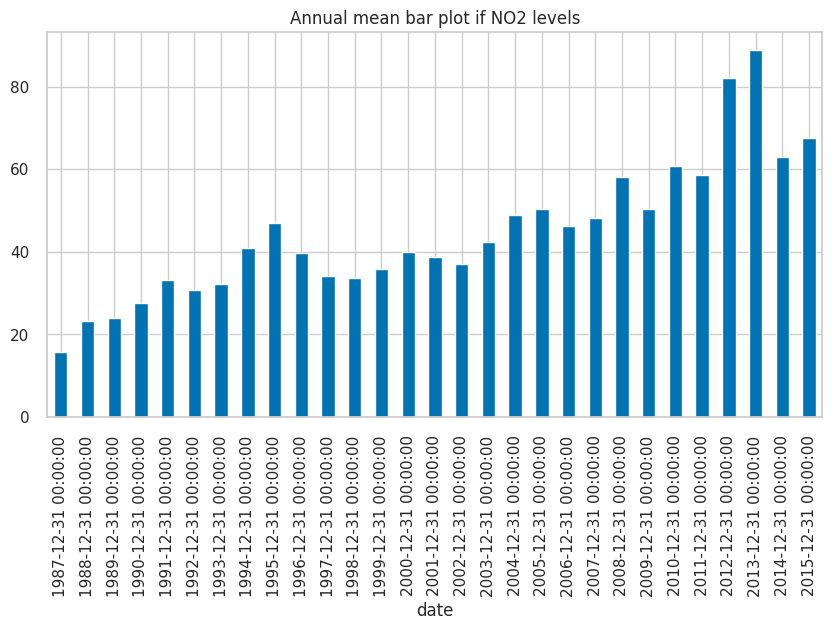

In [ ]:
df_no2_resample_custom["no2"].resample("A").mean().plot.bar(title="Annual mean bar plot if NO2 levels",color="B",figsize = (10,5))

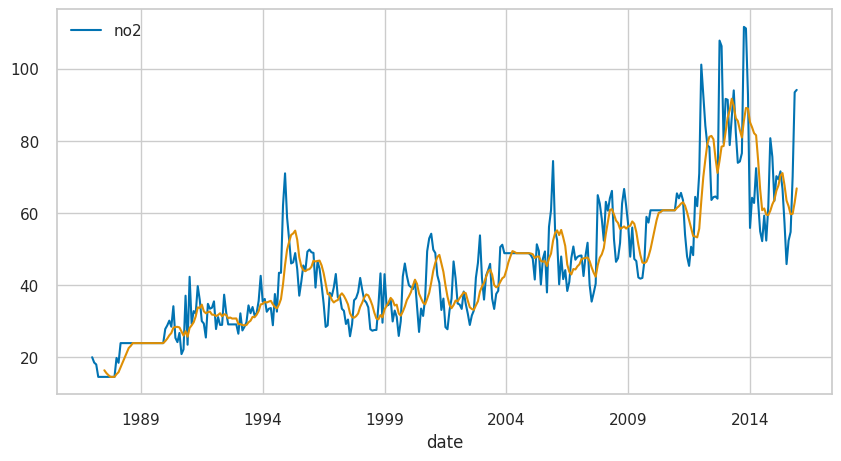

In [ ]:
df_no2_resample_custom.plot(figsize = (10,5))
df_no2_resample_custom.rolling(window = 7).mean()["no2"].plot(figsize = (10,5))

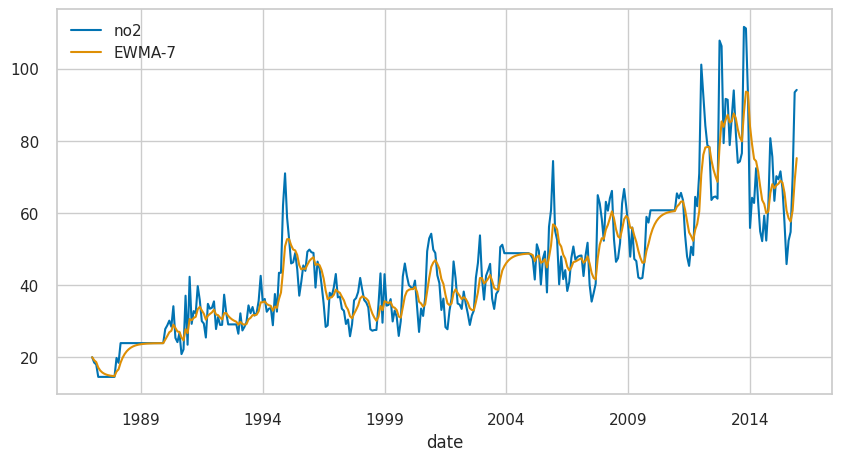

In [ ]:
df_no2_resample_custom["EWMA-7"] = df_no2_resample_custom["no2"].ewm(span=7).mean()
df_no2_resample_custom.plot(figsize = (10,5))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_no2_resample_custom["no2"], model = "multiplicative")

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The colNu

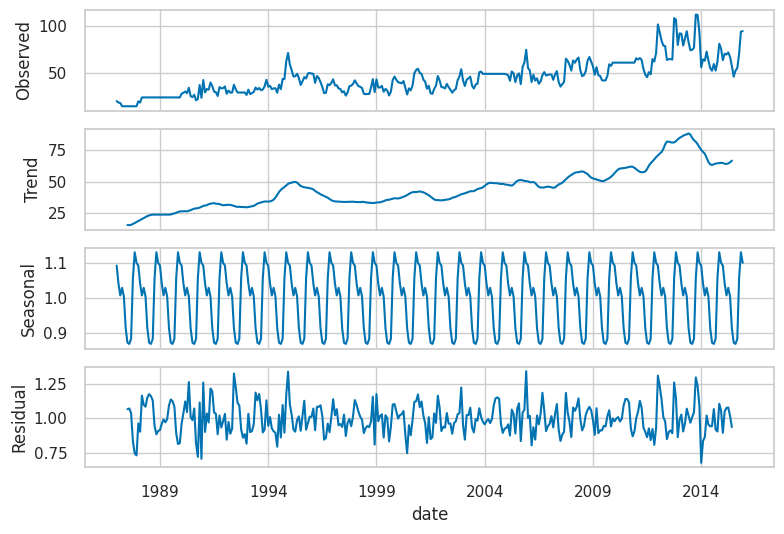

In [ ]:
fig = result.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_no2_resample_custom["no2"])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.2966462851753546
p-value : 0.6307052421179407
#Lags Used : 15
Number of Observations Used : 332
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
df_no2_resample_custom["no2_first_diff"] = df_no2_resample_custom["no2"] - df_no2_resample_custom["no2"].shift(7)
# CHECK
result = adfuller(df_no2_resample_custom["no2_first_diff"].dropna() )
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.238407095647529
p-value : 7.335991388964523e-06
#Lags Used : 17
Number of Observations Used : 323
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
#df_so2_resample_custom["so2_first_diff"].plot(figsize = (20,10))

In [ ]:
df_no2_resample_custom["no2_second_diff"] = df_no2_resample_custom["no2_first_diff"] - df_no2_resample_custom["no2_first_diff"].shift(7)

In [ ]:
import statsmodels.api as sm
import time
start=time.time()
model = sm.tsa.statespace.SARIMAX(df_no2_resample_custom["no2"],order=(0,1,0), seasonal_order=(1,1,1,48))
results = model.fit()
#print(results.summary())
#results.resid.plot()
end=time.time()
timetaken=end-start
print("Time taken to fit the model =",timetaken)

Time taken to fit the model = 10.459342956542969


                   no2   forecast
date                             
1987-01-31   20.050000        NaN
1987-02-28   18.566667        NaN
1987-03-31   18.044444        NaN
1987-04-30   14.600000        NaN
1987-05-31   14.600000        NaN
1987-06-30   14.600000        NaN
1987-07-31   14.600000        NaN
1987-08-31   14.600000        NaN
1987-09-30   14.600000        NaN
1987-10-31   14.600000        NaN
1987-11-30   14.600000        NaN
1987-12-31   14.600000        NaN
1988-01-31   19.860000        NaN
1988-02-29   18.500000        NaN
1988-03-31   23.960000        NaN
1988-04-30   23.960000        NaN
1988-05-31   23.960000        NaN
1988-06-30   23.960000        NaN
1988-07-31   23.960000        NaN
1988-08-31   23.960000        NaN
1988-09-30   23.960000        NaN
1988-10-31   23.960000        NaN
1988-11-30   23.960000        NaN
1988-12-31   23.960000        NaN
1989-01-31   23.960000        NaN
1989-02-28   23.960000        NaN
1989-03-31   23.960000        NaN
1989-04-30   2

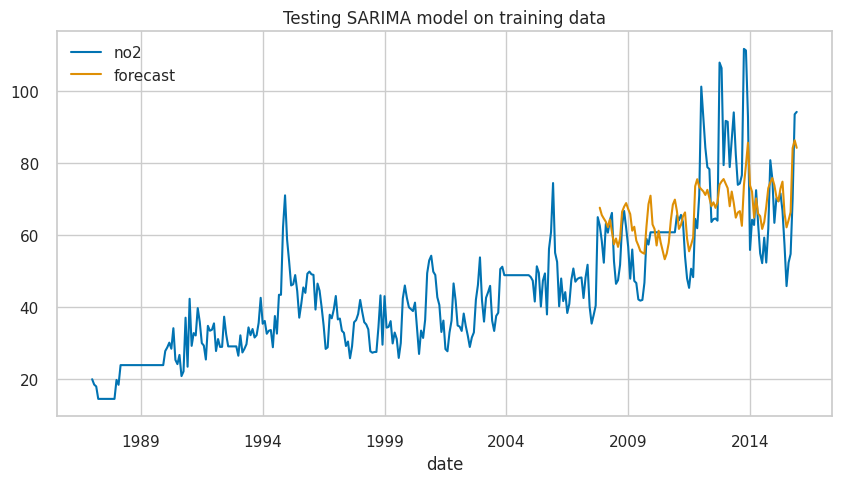

In [ ]:
df_no2_resample_custom['forecast'] = results.predict(start = 250, end= 400, dynamic= True)  
df_no2_resample_custom[['no2','forecast']].plot(title="Testing SARIMA model on training data",figsize=(10,5))
print(df_no2_resample_custom[['no2','forecast']])

In [ ]:
import math
df_no2_resample_custom["diff"] = abs(df_no2_resample_custom["no2"]- df_no2_resample_custom["forecast"])
print(df_no2_resample_custom.query("date> '2013-07-01'")[["no2","forecast","diff"]])
print("Mean Absolute Error =",df_no2_resample_custom.query("date> '2013-07-01'")["diff"].sum()/30)

                   no2   forecast       diff
date                                        
2013-07-31   73.928571  66.242499   7.686072
2013-08-31   74.304348  66.640772   7.663576
2013-09-30   76.600000  62.570166  14.029834
2013-10-31  111.600000  73.738355  37.861645
2013-11-30  111.173913  79.407509  31.766404
2013-12-31   92.740741  85.599129   7.141612
2014-01-31   55.879310  73.753673  17.874363
2014-02-28   64.241379  72.038466   7.797087
2014-03-31   62.796875  64.846141   2.049266
2014-04-30   72.439394  70.164974   2.274420
2014-05-31   63.070423  65.906047   2.835625
2014-06-30   54.928571  65.247845  10.319274
2014-07-31   52.224138  61.705115   9.480977
2014-08-31   59.288462  63.607723   4.319262
2014-09-30   52.381818  67.848898  15.467080
2014-10-31   61.762712  72.996325  11.233613
2014-11-30   80.750000  74.620437   6.129563
2014-12-31   75.578125  75.801067   0.222942
2015-01-31   63.388889  73.831391  10.442502
2015-02-28   70.229508  70.595467   0.365959
2015-03-31

1987-01-31          NaN
1987-02-28          NaN
1987-03-31          NaN
1987-04-30          NaN
1987-05-31          NaN
1987-06-30          NaN
1987-07-31          NaN
1987-08-31          NaN
1987-09-30          NaN
1987-10-31          NaN
1987-11-30          NaN
1987-12-31          NaN
1988-01-31          NaN
1988-02-29          NaN
1988-03-31          NaN
1988-04-30          NaN
1988-05-31          NaN
1988-06-30          NaN
1988-07-31          NaN
1988-08-31          NaN
1988-09-30          NaN
1988-10-31          NaN
1988-11-30          NaN
1988-12-31          NaN
1989-01-31          NaN
1989-02-28          NaN
1989-03-31          NaN
1989-04-30          NaN
1989-05-31          NaN
1989-06-30          NaN
                ...    
2015-06-30    46.941318
2015-07-31    43.239576
2015-08-31    46.159230
2015-09-30    47.228261
2015-10-31    65.484936
2015-11-30    64.268724
2015-12-31    64.123755
2016-01-31    69.239529
2016-02-29    71.654739
2016-03-31    68.108937
2016-04-30    68

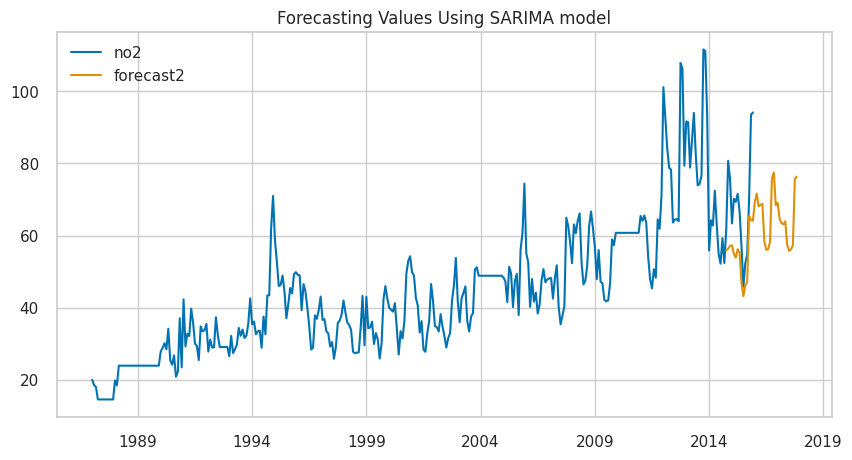

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates_custom = [df_no2_resample_custom.index[-1] + DateOffset(months=x) for x in range(0,24) ]
future_dates_custom_df = pd.DataFrame(index=future_dates_custom[1:],columns=df_no2_resample_custom.columns)
future_df_custom = pd.concat([df_no2_resample_custom,future_dates_custom_df])
future_df_custom['forecast2'] = results.predict(start = 333, end = 540, dynamic= True)  
future_df_custom[['no2', 'forecast2']].plot(title="Forecasting Values Using SARIMA model",figsize=(10, 5))
print(future_df_custom['forecast2'])

# Prediction using Neural Networks

In [ ]:
df_x_nn = df_custom[["date", "no2"]]
df_x_nn = df_x_nn.set_index("date")
df_x_nn = df_x_nn.dropna() 
df_x_nn_filled=df_x_nn.ffill()
df_x_nn_resample=df_x_nn.resample(rule="M").mean().ffill()
train = df_x_nn_resample.query('date >= "1990-01-09"')
valid = df_x_nn_resample.query('date >= "2013-01-01" and date < "2013-12-31"')
test = df_x_nn_resample.query('date >= "2014-01-01" and date < "2015-01-01"')

# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# valid = scaler.transform(valid)
# test = scaler.transform(test)

train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('/content/drive/My Drive/data/train_custom.csv')
valid.to_csv('/content/drive/My Drive/data/valid_custom.csv')
test.to_csv('/content/drive/My Drive/data/test_custom.csv')

In [ ]:
train = pd.read_csv('/content/drive/My Drive/data/train_custom.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('/content/drive/My Drive/data/valid_custom.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('/content/drive/My Drive/data/test_custom.csv', header=0, index_col=0).values.astype('float32')

In [ ]:

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [ ]:
buffer = 7

train_data_gen = TimeseriesGenerator(train, train, length=buffer, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=buffer, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=buffer, sampling_rate=1, stride=1, batch_size = 1)

## Training and Prediction RNN

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1000
61/61 [==============================] - 1s 16ms/step - loss: 41.8301 - val_loss: 85.2346

Epoch 00001: val_loss improved from inf to 85.23457, saving model to /content/drive/My Drive/data/simple_rnn_weights.hdf5
Epoch 2/1000
61/61 [==============================] - 1s 9ms/step - loss: 34.3865 - val_loss: 78.6606

Epoch 00002: val_loss improved from 85.23457 to 78.66062, saving model to /content/drive/My Drive/data/simple_rnn_weights.hdf5
Epoch 3/1000
61/61 [==============================] - 1s 9ms/step - loss: 29.7405 - val_loss: 74.0313

Epoch 00003: val_loss improved from 78.66062 to 74.03127, saving model to /content/drive/My Drive/data/simple_rnn_weights.hdf5
Epoch 4/1000
61/61 [==============================] - 1s 9ms/step - loss: 25.6135 - val_loss: 69.9365

Epoch 00004: val_loss improved from 74.03127 to 69.93649, saving model to /content/drive/My Drive/data/simple_rnn_weights.hdf5
Ep

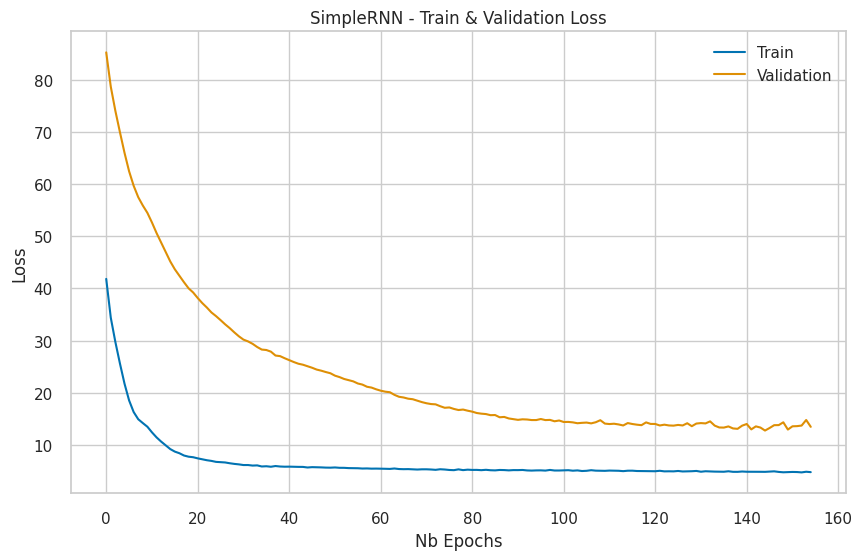

Minimum validation loss of 12.767822265625 reached at epoch 144
Time taken by RNN =  88.40442514419556


In [ ]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(64, input_shape=(buffer, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())
import time
start=time.time()
checkpointer = ModelCheckpoint(filepath= '/content/drive/My Drive/data/simple_rnn_weights.hdf5'
                               , save_best_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10)
with open("/content/drive/My Drive/data/simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=1000
                                              , validation_data=valid_data_gen
                                              , callbacks=[checkpointer, earlystopper],verbose=1)
simple_rnn.save("/content/drive/My Drive/data/custom_rnn")
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')
end=time.time()
tt=end-start
(print('Time taken by RNN = ',tt))

In [ ]:
rnn_loaded= load_model("/content/drive/My Drive/data/custom_rnn")
forecast_rnn=rnn_loaded.predict(test_data_gen)
print("The forecasted values are:")
print(forecast_rnn)
print()
print("The test values are")
print(test[:-1])


The forecasted values are:
[[53.151775]
 [60.75568 ]
 [51.81124 ]
 [63.341076]
 [76.31887 ]]

The test values are
[[55.87931 ]
 [64.24138 ]
 [62.796875]
 [72.43939 ]
 [63.070423]
 [54.92857 ]
 [52.224136]
 [59.28846 ]
 [52.381817]
 [61.76271 ]
 [80.75    ]]


## Training and Prediction Simple LSTM

Epoch 1/1000
61/61 [==============================] - 1s 16ms/step - loss: 43.1670 - val_loss: 86.2232

Epoch 00001: val_loss improved from inf to 86.22324, saving model to /content/drive/My Drive/data/simple_lstm_weights.hdf5
Epoch 2/1000
61/61 [==============================] - 1s 12ms/step - loss: 36.1458 - val_loss: 80.0098

Epoch 00002: val_loss improved from 86.22324 to 80.00981, saving model to /content/drive/My Drive/data/simple_lstm_weights.hdf5
Epoch 3/1000
61/61 [==============================] - 1s 11ms/step - loss: 31.2058 - val_loss: 75.3018

Epoch 00003: val_loss improved from 80.00981 to 75.30180, saving model to /content/drive/My Drive/data/simple_lstm_weights.hdf5
Epoch 4/1000
61/61 [==============================] - 1s 11ms/step - loss: 27.1322 - val_loss: 71.2982

Epoch 00004: val_loss improved from 75.30180 to 71.29820, saving model to /content/drive/My Drive/data/simple_lstm_weights.hdf5
Epoch 5/1000
61/61 [==============================] - 1s 11ms/step - loss: 23

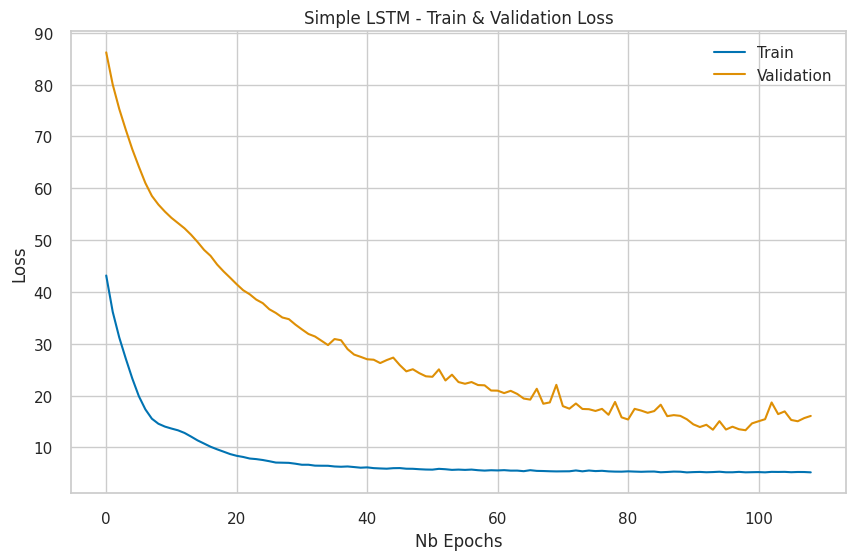

Minimum validation loss of 13.3131103515625 reached at epoch 98
Time Taken by LSTM=  80.79562878608704


In [ ]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(64, input_shape=(buffer, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())
start=time.time()
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/data/simple_lstm_weights.hdf5'
                               , save_best_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10)
with open("/content/drive/My Drive/data/simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=1000
                                                , validation_data=valid_data_gen
                                                , callbacks=[checkpointer, earlystopper],verbose=1)
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')
simple_lstm.save("/content/drive/My Drive/data/custom_lstm")
end=time.time()
tt=end-start
print('Time Taken by LSTM= ',tt)

In [ ]:
lstm_loaded= load_model("/content/drive/My Drive/data/custom_lstm")
forecast_lstm=lstm_loaded.predict(test_data_gen)
print(forecast_lstm)
print()
print(test)

[[51.49423 ]
 [60.09658 ]
 [51.86455 ]
 [60.529892]
 [74.09562 ]]

[[55.87931 ]
 [64.24138 ]
 [62.796875]
 [72.43939 ]
 [63.070423]
 [54.92857 ]
 [52.224136]
 [59.28846 ]
 [52.381817]
 [61.76271 ]
 [80.75    ]
 [75.578125]]


## Training and Prediction Stacked LSTM

Epoch 1/1000
61/61 [==============================] - 2s 28ms/step - loss: 42.0196 - val_loss: 85.3866
Epoch 2/1000
61/61 [==============================] - 1s 16ms/step - loss: 37.9901 - val_loss: 83.0533
Epoch 3/1000
61/61 [==============================] - 1s 16ms/step - loss: 35.8467 - val_loss: 81.0101
Epoch 4/1000
61/61 [==============================] - 1s 16ms/step - loss: 33.8263 - val_loss: 78.9954
Epoch 5/1000
61/61 [==============================] - 1s 16ms/step - loss: 31.8128 - val_loss: 76.9823
Epoch 6/1000
61/61 [==============================] - 1s 16ms/step - loss: 29.7998 - val_loss: 74.9693
Epoch 7/1000
61/61 [==============================] - 1s 16ms/step - loss: 27.7868 - val_loss: 72.9564
Epoch 8/1000
61/61 [==============================] - 1s 16ms/step - loss: 25.7821 - val_loss: 70.9463
Epoch 9/1000
61/61 [==============================] - 1s 16ms/step - loss: 23.8154 - val_loss: 68.9587
Epoch 10/1000
61/61 [==============================] - 1s 16ms/step - los

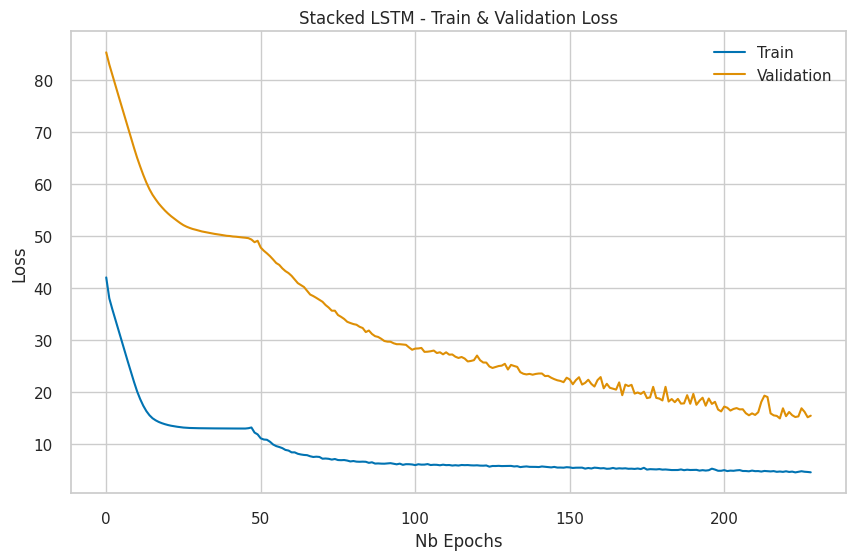

Minimum validation loss of 14.853782653808594 reached at epoch 218
Time Taken by Stacked LSTM=  235.27480220794678


In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(64, input_shape=(buffer, 1), return_sequences=True))
# stacked_lstm.add(LSTM(16, return_sequences=True))
# stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(32))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())
import time
start=time.time()
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/data/stacked_lstm_weights.hdf5'
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10)
with open("/content/drive/My Drive/data/stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=1000
                                                  , validation_data=valid_data_gen
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')
stacked_lstm.save("/content/drive/My Drive/data/custom_stacked_lstm")
end=time.time()
tt=end-start
print('Time Taken by Stacked LSTM= ',tt)

In [ ]:
stacked_lstm_loaded= load_model("/content/drive/My Drive/data/custom_stacked_lstm")
forecast_stacked_lstm=stacked_lstm_loaded.predict(test_data_gen)
print(forecast_stacked_lstm)
print()
print(test[:-1])

[[50.357494]
 [59.08682 ]
 [58.59567 ]
 [66.00856 ]
 [77.605865]]

[[55.87931 ]
 [64.24138 ]
 [62.796875]
 [72.43939 ]
 [63.070423]
 [54.92857 ]
 [52.224136]
 [59.28846 ]
 [52.381817]
 [61.76271 ]
 [80.75    ]]


In [ ]:
def eval_best_model(model):
    
    model_architecture = open('/content/drive/My Drive/data/'+model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    
    best_model.load_weights('/content/drive/My Drive/data/'+model+'_weights.hdf5')
    
    best_model.compile(loss='mae', optimizer=RMSprop())
    
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')
eval_best_model('simple_lstm')
eval_best_model('stacked_lstm')

Loss on test data for simple_rnn : 4.18133544921875
Loss on test data for simple_lstm : 2.2668228149414062
Loss on test data for stacked_lstm : 2.3322906494140625


# All test

In [ ]:
sns.catplot(x = "type", kind = "count",  data = df, height=5, aspect = 4)

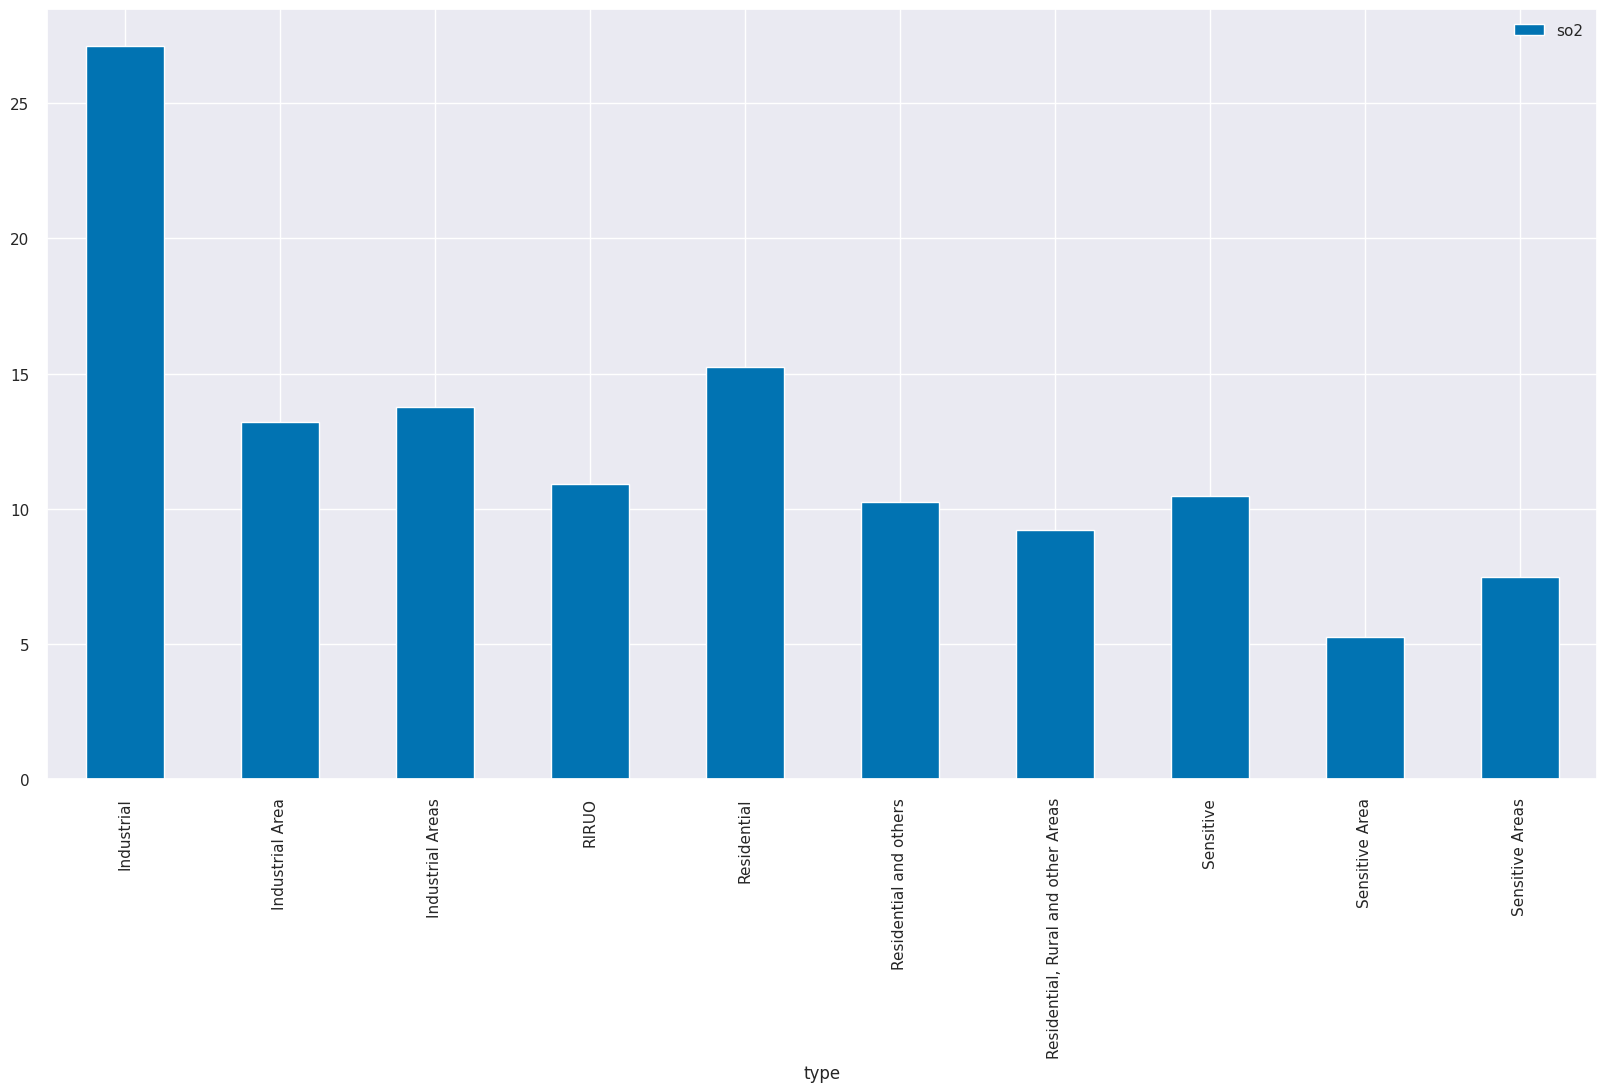

In [ ]:
grp = df.groupby(["type"]).mean()["so2"].to_frame()
grp.plot.bar(figsize = (20,10))

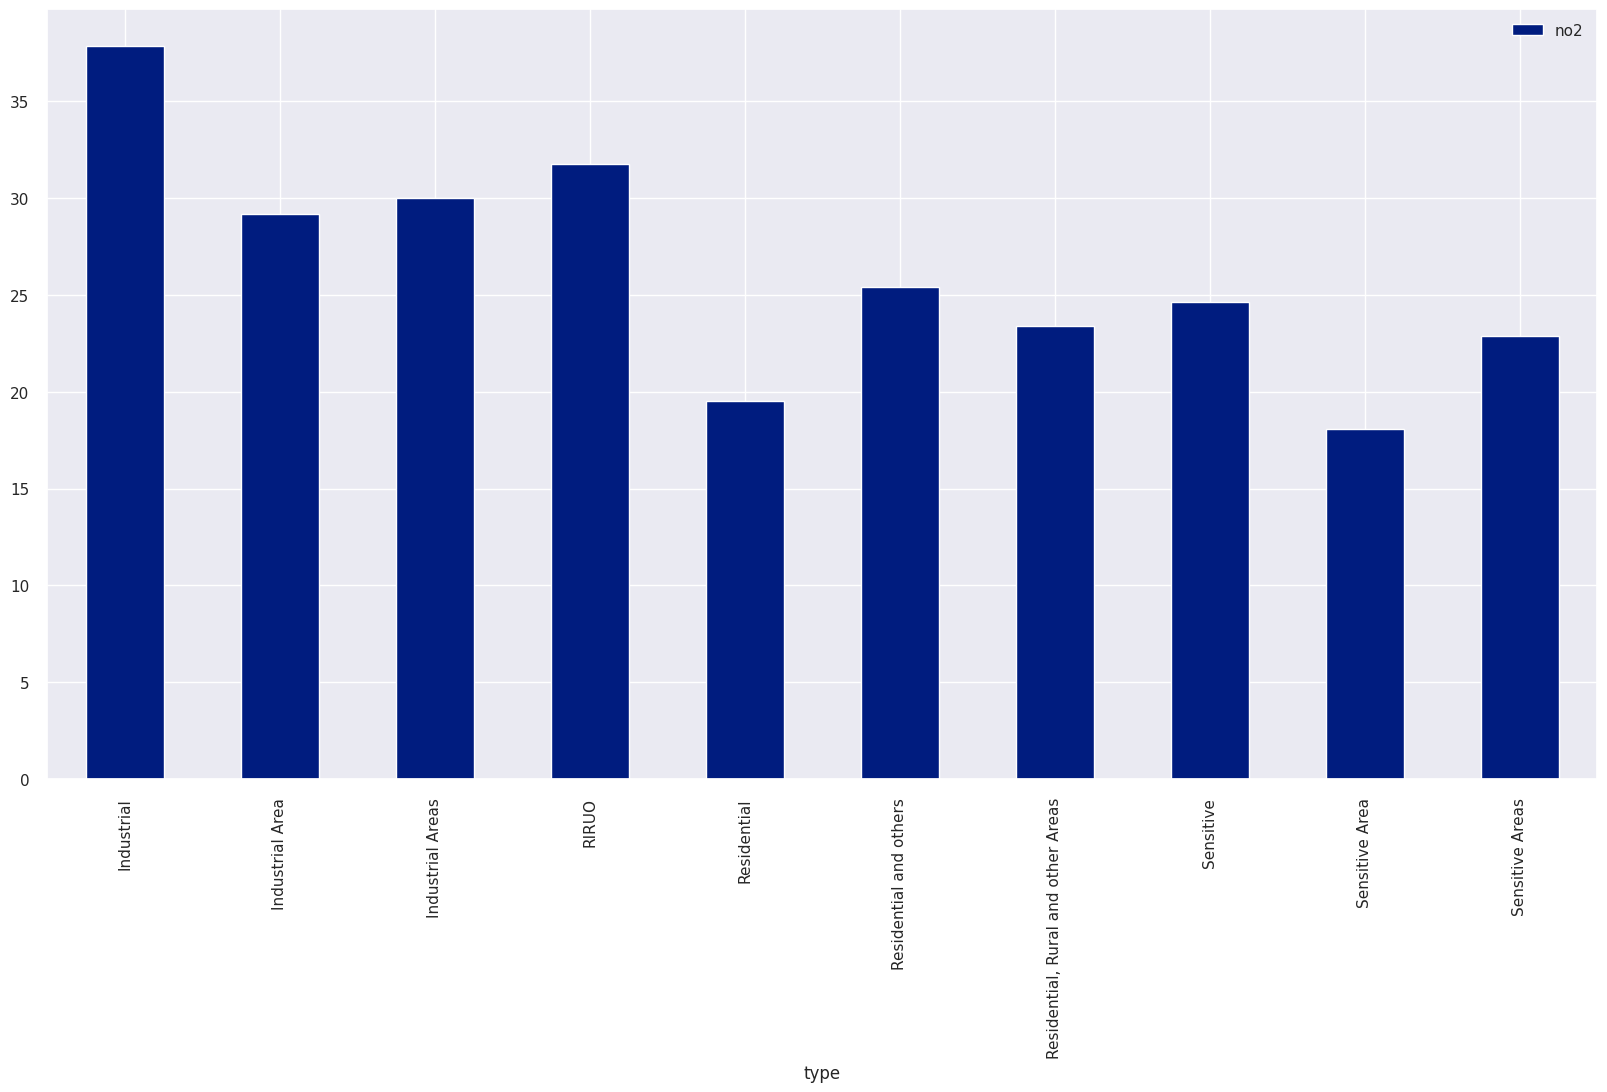

In [ ]:
grp = df.groupby(["type"]).mean()["no2"].to_frame()
grp.plot.bar(figsize = (20,10))

In [ ]:
df_delhi=df.loc[df['state'] == "Delhi"]
print(df_delhi)

      stn_code sampling_date  state  ...   pm2_5       date  year
65861       60      09/01/87  Delhi  ...     NaN 1987-01-09  1987
65862       59      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65863       58      09/03/87  Delhi  ...     NaN 1987-03-09  1987
65864       57      09/03/87  Delhi  ...     NaN 1987-03-09  1987
65865       56      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65866       55      09/02/87  Delhi  ...     NaN 1987-02-09  1987
65867       60      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65868       59      10/04/87  Delhi  ...     NaN 1987-04-10  1987
65869       58      10/01/87  Delhi  ...     NaN 1987-01-10  1987
65870       57      10/01/87  Delhi  ...     NaN 1987-01-10  1987
65871       56      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65872       55      10/03/87  Delhi  ...     NaN 1987-03-10  1987
65873       60      11/02/87  Delhi  ...     NaN 1987-02-11  1987
65874       59      11/03/87  Delhi  ...     NaN 1987-03-11  1987
65875     

In [ ]:
df_custom_so2 = df_delhi[["date", "so2"]]
df_custom_so2 = df_custom_so2.set_index("date")
df_custom_so2 = df_custom_so2.dropna()
df_custom_filled_so2=df_custom_so2.ffill()
df_so2_resample_custom = df_custom_so2.resample(rule = "M").mean().ffill()

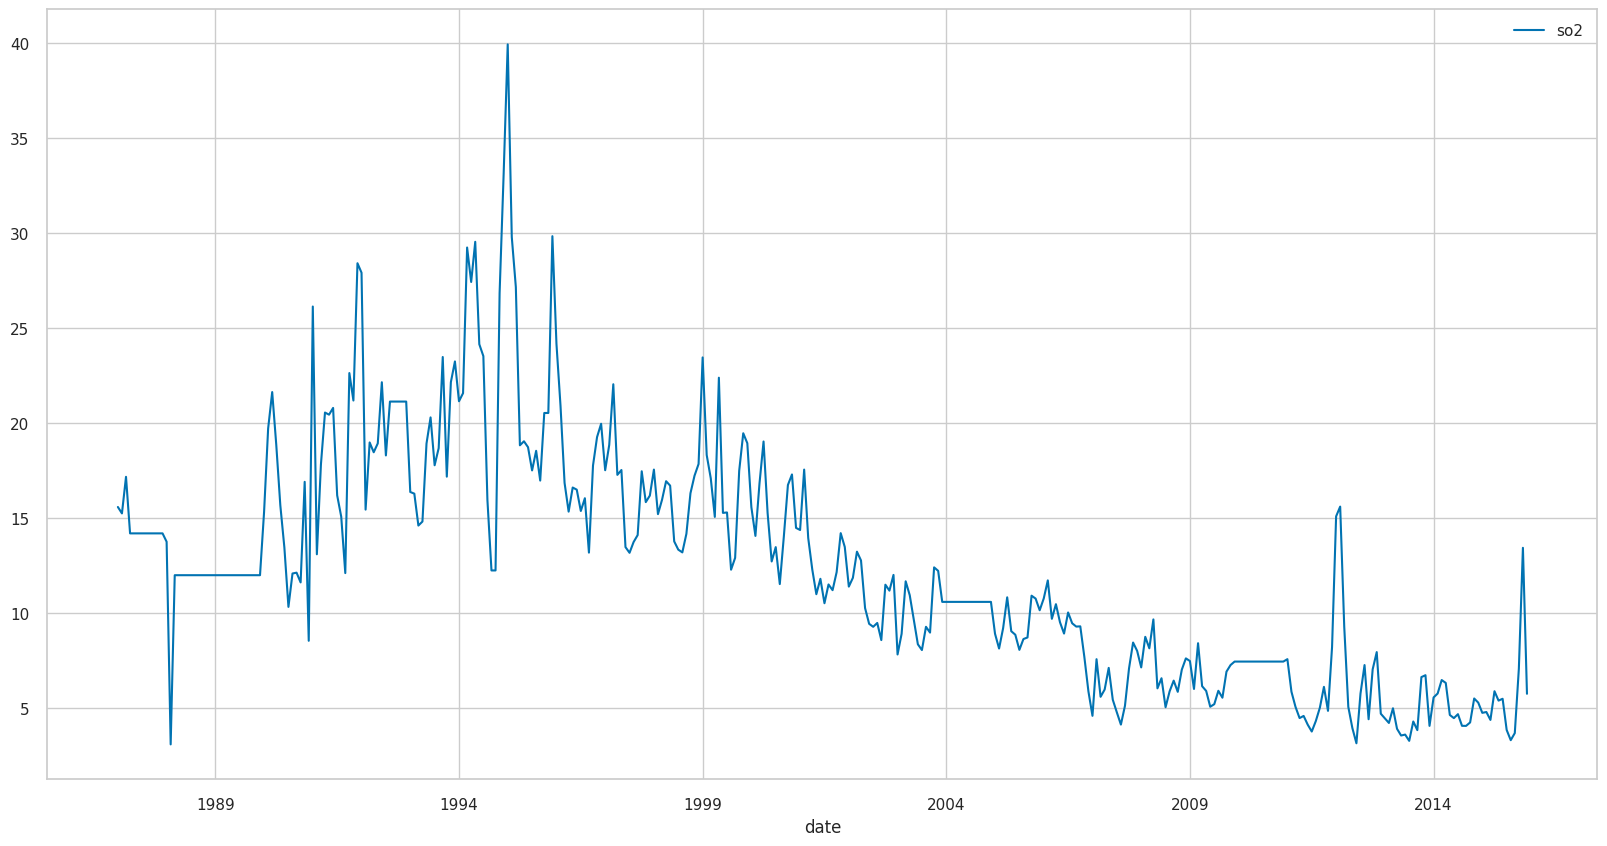

In [ ]:
df_so2_resample_custom.plot(figsize = (20,10))

In [ ]:
train = df_so2_resample_custom.query('date >= "1987-01-09"')
valid = df_so2_resample_custom.query('date >= "2013-01-01" and date < "2013-12-31"')
test = df_so2_resample_custom.query('date >= "2014-01-01" and date < "2015-01-01"')

In [ ]:
print(train)

                  so2
date                 
1987-01-31  15.587500
1987-02-28  15.250000
1987-03-31  17.175000
1987-04-30  14.200000
1987-05-31  14.200000
1987-06-30  14.200000
1987-07-31  14.200000
1987-08-31  14.200000
1987-09-30  14.200000
1987-10-31  14.200000
1987-11-30  14.200000
1987-12-31  14.200000
1988-01-31  13.760000
1988-02-29   3.100000
1988-03-31  12.000000
1988-04-30  12.000000
1988-05-31  12.000000
1988-06-30  12.000000
1988-07-31  12.000000
1988-08-31  12.000000
1988-09-30  12.000000
1988-10-31  12.000000
1988-11-30  12.000000
1988-12-31  12.000000
1989-01-31  12.000000
1989-02-28  12.000000
1989-03-31  12.000000
1989-04-30  12.000000
1989-05-31  12.000000
1989-06-30  12.000000
...               ...
2013-07-31   3.285714
2013-08-31   4.304348
2013-09-30   3.850000
2013-10-31   6.640000
2013-11-30   6.739130
2013-12-31   4.074074
2014-01-31   5.568966
2014-02-28   5.775862
2014-03-31   6.484375
2014-04-30   6.333333
2014-05-31   4.647887
2014-06-30   4.482143
2014-07-31

In [ ]:
# print(train)
#print(valid)
print(max(test["so2"]))


6.484375


In [ ]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# valid = scaler.transform(valid)
# test = scaler.transform(test)

In [ ]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('/content/drive/My Drive/data/train.csv')
valid.to_csv('/content/drive/My Drive/data/valid.csv')
test.to_csv('/content/drive/My Drive/data/test.csv')

In [ ]:
print(train["so2"])

date
1987-01-31    15.587500
1987-02-28    15.250000
1987-03-31    17.175000
1987-04-30    14.200000
1987-05-31    14.200000
1987-06-30    14.200000
1987-07-31    14.200000
1987-08-31    14.200000
1987-09-30    14.200000
1987-10-31    14.200000
1987-11-30    14.200000
1987-12-31    14.200000
1988-01-31    13.760000
1988-02-29     3.100000
1988-03-31    12.000000
1988-04-30    12.000000
1988-05-31    12.000000
1988-06-30    12.000000
1988-07-31    12.000000
1988-08-31    12.000000
1988-09-30    12.000000
1988-10-31    12.000000
1988-11-30    12.000000
1988-12-31    12.000000
1989-01-31    12.000000
1989-02-28    12.000000
1989-03-31    12.000000
1989-04-30    12.000000
1989-05-31    12.000000
1989-06-30    12.000000
                ...    
2013-07-31     3.285714
2013-08-31     4.304348
2013-09-30     3.850000
2013-10-31     6.640000
2013-11-30     6.739130
2013-12-31     4.074074
2014-01-31     5.568966
2014-02-28     5.775862
2014-03-31     6.484375
2014-04-30     6.333333
2014-05-31 

In [ ]:
train = pd.read_csv('/content/drive/My Drive/data/train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('/content/drive/My Drive/data/valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('/content/drive/My Drive/data/test.csv', header=0, index_col=0).values.astype('float32')


In [ ]:

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [ ]:
n_lag = 7

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

Epoch 1/10
341/341 [==============================] - 1s 4ms/step - loss: 10.7699 - accuracy: 0.0000e+00 - val_loss: 3.3289 - val_accuracy: 0.0000e+00
Epoch 2/10
341/341 [==============================] - 1s 3ms/step - loss: 9.0319 - accuracy: 0.0000e+00 - val_loss: 1.6736 - val_accuracy: 0.0000e+00
Epoch 3/10
341/341 [==============================] - 1s 3ms/step - loss: 7.6162 - accuracy: 0.0000e+00 - val_loss: 0.2482 - val_accuracy: 0.0029
Epoch 4/10
341/341 [==============================] - 1s 3ms/step - loss: 6.6848 - accuracy: 0.0000e+00 - val_loss: 0.8776 - val_accuracy: 0.0000e+00
Epoch 5/10
341/341 [==============================] - 1s 3ms/step - loss: 6.0714 - accuracy: 0.0000e+00 - val_loss: 1.8054 - val_accuracy: 0.0000e+00
Epoch 6/10
341/341 [==============================] - 1s 3ms/step - loss: 5.6335 - accuracy: 0.0000e+00 - val_loss: 2.5153 - val_accuracy: 0.0000e+00
Epoch 7/10
341/341 [==============================] - 1s 3ms/step - loss: 5.2476 - accuracy: 0.0000e+00

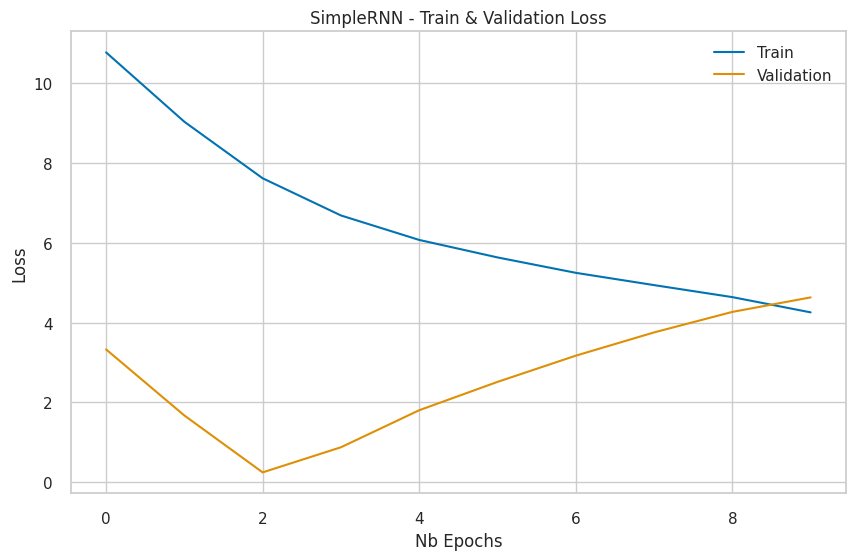

Minimum validation loss of 0.24817514419555664 reached at epoch 2


In [ ]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop(), metrics=["accuracy"])

checkpointer = ModelCheckpoint(filepath= '/content/drive/My Drive/data/simple_rnn_weights_100epoch_so2_delhi.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=10
                                              , validation_data=valid_data_gen
                                              , callbacks=[checkpointer, earlystopper])
simple_rnn.save("/content/drive/My Drive/data/123")
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [ ]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/data/simple_lstm_weights_100epoch_so2_delhi.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=100
                                                , validation_data=valid_data_gen
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

KeyboardInterrupt: ignored

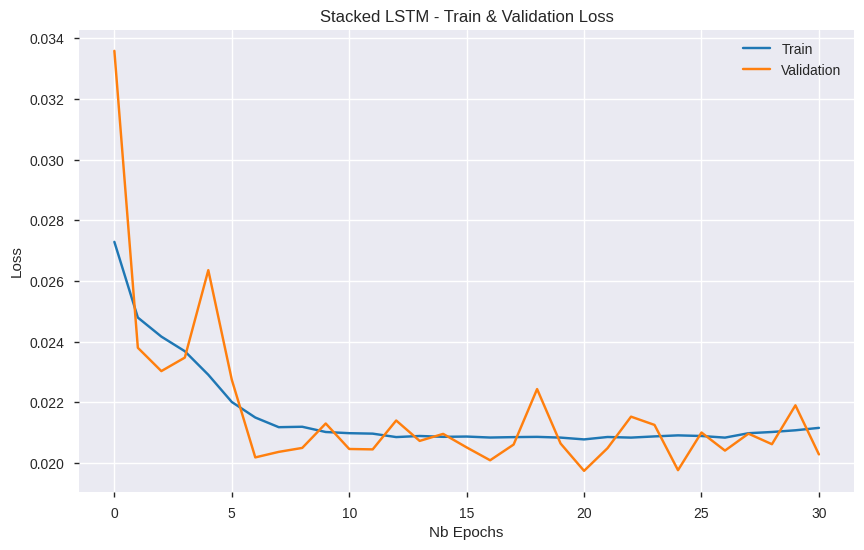

Minimum validation loss of 0.01974766771094047 reached at epoch 20


In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=500
                                                  , validation_data=valid_data_gen
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

In [ ]:
from keras.models import load_model

In [ ]:
print(test_data_gen)

In [ ]:
abc=load_model("/content/drive/My Drive/data/123")
lsd=abc.predict(test_data_gen)
loss=abc.evaluate_generator(test_data_gen)
print(lsd)

[[6.137252 ]
 [5.821394 ]
 [6.01098  ]
 [6.284645 ]
 [7.9700074]]


In [ ]:
lsd=abc.predict(test_data_gen)


In [ ]:
loss=abc.evaluate_generator(test_data_gen)

In [ ]:

print(loss)

[2.6731324195861816, 0.0]


In [ ]:
print(lsd)

[[6.137252 ]
 [5.821394 ]
 [6.01098  ]
 [6.284645 ]
 [7.9700074]]


In [ ]:
print(test)

[[5.5689654]
 [5.775862 ]
 [6.484375 ]
 [6.3333335]
 [4.647887 ]
 [4.482143 ]
 [4.6896553]
 [4.076923 ]
 [4.072727 ]
 [4.254237 ]
 [5.5147057]
 [5.296875 ]]


In [ ]:
import math
msd=0
for i in range(len(lsd)):
  msd+=math.sqrt(abs((lsd[i]**2-test[i+7]**2)))

msd=msd/len(lsd)
print(msd)

print(max(test))

0.03579857232492241
[0.09191121]


In [ ]:
def eval_best_model(model):
    # Load model architecture from JSON
    model_architecture = open('../model/'+model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('../model/'+model+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mae', optimizer=RMSprop())
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')

FileNotFoundError: ignored

In [ ]:
state1=input("Enter Name of State: ")

Enter Name of StateGujarat


In [ ]:
df_interact=df.loc[df['state'] == state1]
print(df_interact)

       stn_code sampling_date    state  ... pm2_5       date  year
80618        49      1/2/1987  Gujarat  ...   NaN 1987-02-01  1987
80619        47      1/1/1987  Gujarat  ...   NaN 1987-01-01  1987
80620        50      1/2/1987  Gujarat  ...   NaN 1987-02-01  1987
80621        48      1/1/1987  Gujarat  ...   NaN 1987-01-01  1987
80622        51      1/1/1987  Gujarat  ...   NaN 1987-01-01  1987
...         ...           ...      ...  ...   ...        ...   ...
101892     SAMP      13-03-15  Gujarat  ...  35.0 2015-03-13  2015
101893     SAMP      17-03-15  Gujarat  ...  32.0 2015-03-17  2015
101894     SAMP      20-03-15  Gujarat  ...  30.0 2015-03-20  2015
101895     SAMP      24-03-15  Gujarat  ...  34.0 2015-03-24  2015
101896     SAMP      27-03-15  Gujarat  ...  31.0 2015-03-27  2015

[21279 rows x 14 columns]
